# Fixed Income Analytics (Draft)
## A Comprehensive Tutorial with Python

**Topics Covered:**
- Fixed Income Financial Instruments (Coupon Bonds, Zero-Coupon Bonds)
- Bond Pricing
    - Discounted Cash Flow Valuation
    - Term Structure of Interest Rates (Spot Rate Curve)
- Bond Return Analysis
    - Bond Yields: Coupon Yield, Current Yield, and Yield to Maturity
    - Discount, Par, and Premium Bonds
    - The Pull-to-Par Effect
    - Expected Total Returns for Bonds
    - Expected Total Return Decompositions
    - Modelling Expected Price Returns
- Bond Risk Analysis
    - ...

Andreas Steiner Consulting GmbH, November 2025

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve
from scipy.optimize import minimize

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

---
# 1. Fixed Income Financial Instruments
---

A bond is a debt security where the issuer owes the holder a debt and is obliged to pay interest (coupon) and/or repay the principal at maturity.

## Key Bond Parameters:

- **Face Value ($F$)**: The par or nominal value (in dollars)
- **Maturity ($m$)**: Number of years until the bond's principal is repaid
- **Coupon Payment ($c$)**: Annual cash payment to the bondholder (in dollars)

This is a stylized bond. Real-world bond instruments have many more features that we ignore here.

In [2]:
# Define example parameters
F = 1000  # Face value in dollars
c = 50    # Annual coupon payment in dollars
m = 5     # Maturity in years

print(f"Example Bond Parameters:")
print(f"  Face Value (F): {F}")
print(f"  Annual Coupon Payment (c): {c}")
print(f"  Maturity (m): {m} years")

Example Bond Parameters:
  Face Value (F): 1000
  Annual Coupon Payment (c): 50
  Maturity (m): 5 years


## 1.1 Coupon Bonds

A **coupon bond** makes periodic cash payments (coupons) at regular intervals and repays the face value at maturity.

### Cash Flow Structure:
- **Periodic coupon payments**: $c$ dollars per year
- **Final payment at maturity**: $c + F$ (coupon plus face value)

For a bond with:
- Face value: 1,000
- Annual coupon payment: 50
- 5-year maturity

The bondholder receives 50 each year for 5 years, plus 1,000 at the end of year 5.

In [3]:
# Create cash flow schedule for coupon bond
periods = np.arange(1, m + 1)
coupon_payments = np.full(m, c)
coupon_payments[-1] += F  # Add face value to final payment

cash_flow_df = pd.DataFrame({
    'Year': periods,
    'Coupon Payment': np.where(periods < m, c, c),
    'Principal Payment': np.where(periods == m, F, 0),
    'Total Cash Flow': coupon_payments
})

print("Cash Flow Schedule for Coupon Bond:")
display(cash_flow_df)

Cash Flow Schedule for Coupon Bond:


,Year,Coupon Payment,Principal Payment,Total Cash Flow
0,1,50,0,50
1,2,50,0,50
2,3,50,0,50
3,4,50,0,50
4,5,50,1000,1050


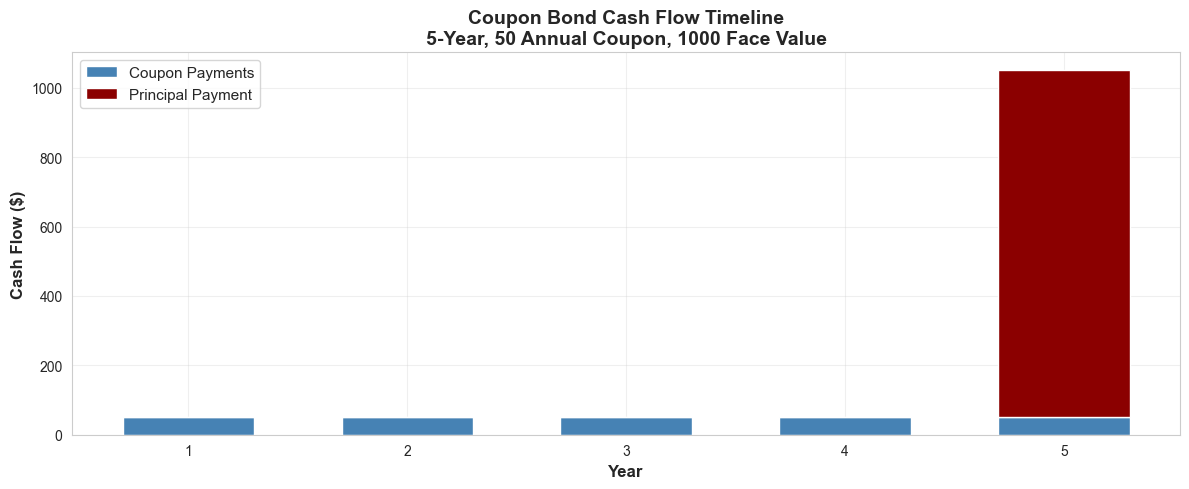

In [4]:
# Visualize coupon bond cash flows
fig, ax = plt.subplots(figsize=(12, 5))
years = cash_flow_df['Year']
coupons = cash_flow_df['Coupon Payment']
principal = cash_flow_df['Principal Payment']

ax.bar(years, coupons, width=0.6, label='Coupon Payments', color='steelblue')
ax.bar(years, principal, bottom=coupons, width=0.6, 
       label='Principal Payment', color='darkred')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Cash Flow ($)', fontsize=12, fontweight='bold')
ax.set_title('Coupon Bond Cash Flow Timeline\n5-Year, 50 Annual Coupon, 1000 Face Value', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(years)
plt.tight_layout()
plt.show()

## 1.2 Zero-Coupon Bonds

A **zero-coupon bond** makes NO periodic cash payments. It is sold at a discount to face value and pays only the face value at maturity. The return comes entirely from price appreciation.

### Characteristics:
- No coupon payments during the life of the bond
- Single cash flow at maturity: $F$
- Purchased at a discounted price
- Return = Face Value - Purchase Price

### Example:
A 5-year zero-coupon bond with 1,000 face value:
- **Years 1-4**: No cash flows
- **Year 5**: Receive 1,000

In [5]:
# Zero-coupon bond cash flow schedule
zero_cf_df = pd.DataFrame({
    'Year': [m],
    'Cash Flow': [F]
})

print("Cash Flow Schedule for Zero-Coupon Bond:")
display(zero_cf_df)

Cash Flow Schedule for Zero-Coupon Bond:


,Year,Cash Flow
0,5,1000


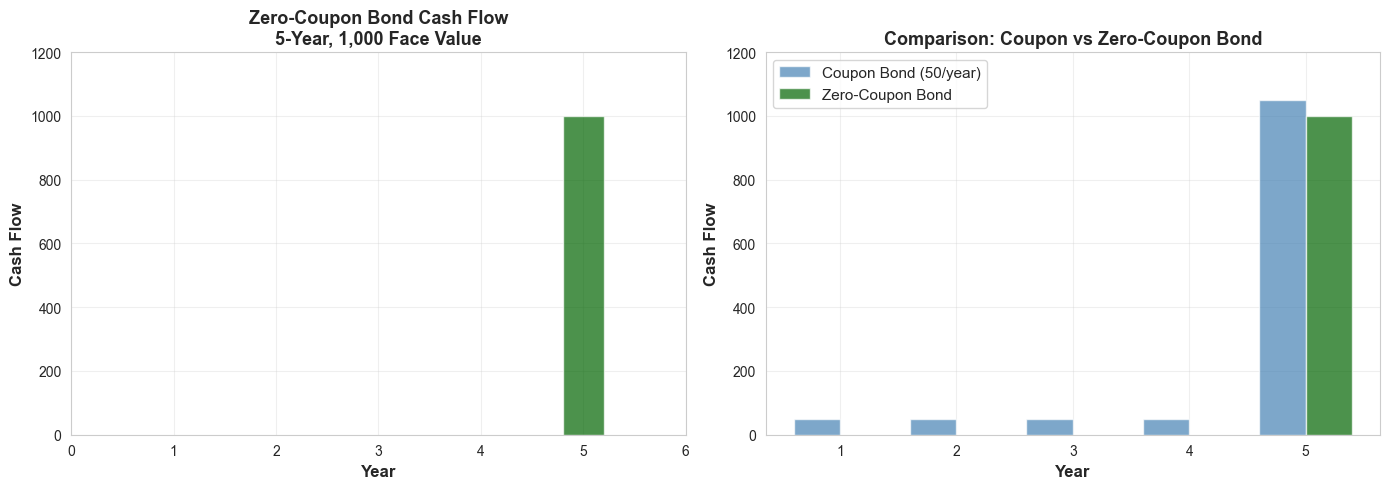

In [6]:
# Visualize zero-coupon bond vs coupon bond
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Zero-coupon cash flow
ax1.bar([5], [1000], width=0.4, color='darkgreen', alpha=0.7)
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cash Flow', fontsize=12, fontweight='bold')
ax1.set_title('Zero-Coupon Bond Cash Flow\n5-Year, 1,000 Face Value', 
              fontsize=13, fontweight='bold')
ax1.set_xlim(0, 6)
ax1.set_ylim(0, 1200)
ax1.grid(True, alpha=0.3)

# Comparison
years_coupon = cash_flow_df['Year']
ax2.bar(years_coupon - 0.2, cash_flow_df['Total Cash Flow'], 
        width=0.4, label='Coupon Bond (50/year)', color='steelblue', alpha=0.7)
ax2.bar([5 + 0.2], [1000], width=0.4, label='Zero-Coupon Bond', 
        color='darkgreen', alpha=0.7)
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cash Flow', fontsize=12, fontweight='bold')
ax2.set_title('Comparison: Coupon vs Zero-Coupon Bond', 
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1200)

plt.tight_layout()
plt.show()

---
# 2. Bond Pricing - Discounted Cash Flow Valuation and Spot Rate Curves
---

The fundamental principle of bond pricing is that the **bond price equals the present value of all future cash flows**, where each cash flow is discounted using the appropriate **discount rate**.

## 2.1 Spot Rates and the Term Structure

The **spot rate** is the relevant discount rate for a single cash flow occurring at time $t$. The collection of spot rates for different maturities forms the **term structure of interest rates** (or **spot rate curve**).

### Key Properties:

- **Spot Rate $r_t$**: The discount rate applied to a cash flow received at time $t$ years
- **Term Structure**: The relationship $r_1, r_2, r_3, \ldots, r_n$ for different maturities
- **Example**: 
  - 1-year spot rate: $r_1 = 3.0\%$
  - 2-year spot rate: $r_2 = 3.5\%$
  - 3-year spot rate: $r_3 = 4.0\%$
  - 5-year spot rate: $r_5 = 4.5\%$

The term structure can be:
- **Upward sloping**: Longer-dated spot rates are higher (normal)
- **Downward sloping**: Longer-dated spot rates are lower (flat/inverted)
- **Flat**: All spot rates are equal

We assume that the term structure of spot rates is given. Deriving spot rates from traded fixed income instruments will be covered later.

## 2.2 Bond Pricing with Spot Rates

### Coupon Bond Pricing Formula

The price of a coupon bond is the present value of all future cash flows, discounted at the corresponding spot rates:

$$P = \sum_{t=1}^{n-1} \frac{c}{(1 + r_t)^t} + \frac{c + F}{(1 + r_n)^n}$$

Where:
- $P$ = Bond price
- $c$ = Coupon payment (in dollars)
- $r_t$ = Spot rate for maturity $t$ (annual)
- $F$ = Face value
- $n$ = Maturity in years

### Zero-Coupon Bond Pricing Formula

For a zero-coupon bond with maturity $n$:

$$P = \frac{F}{(1 + r_n)^n}$$

This simplifies to a single discounted cash flow at maturity, discounted at the $n$-year spot rate.

## Define a Spot Rate Curve

In [7]:
# Define a spot rate curve (term structure)
# Upward sloping curve: longer maturities have higher spot rates
maturities_curve = np.array([1, 2, 3, 4, 5, 7, 10])
spot_rates = np.array([0.030, 0.035, 0.039, 0.043, 0.046, 0.050, 0.053])  # Annual rates

spot_rate_df = pd.DataFrame({
    'Maturity (Years)': maturities_curve,
    'Spot Rate (%)': spot_rates * 100,
    'Discount Factor': 1 / (1 + spot_rates) ** maturities_curve
})

print("Term Structure of Spot Rates:")
display(spot_rate_df)

Term Structure of Spot Rates:


,Maturity (Years),Spot Rate (%),Discount Factor
0,1,3.0,0.970874
1,2,3.5,0.933511
2,3,3.9,0.891566
3,4,4.3,0.845012
4,5,4.6,0.798623
5,7,5.0,0.710681
6,10,5.3,0.596645


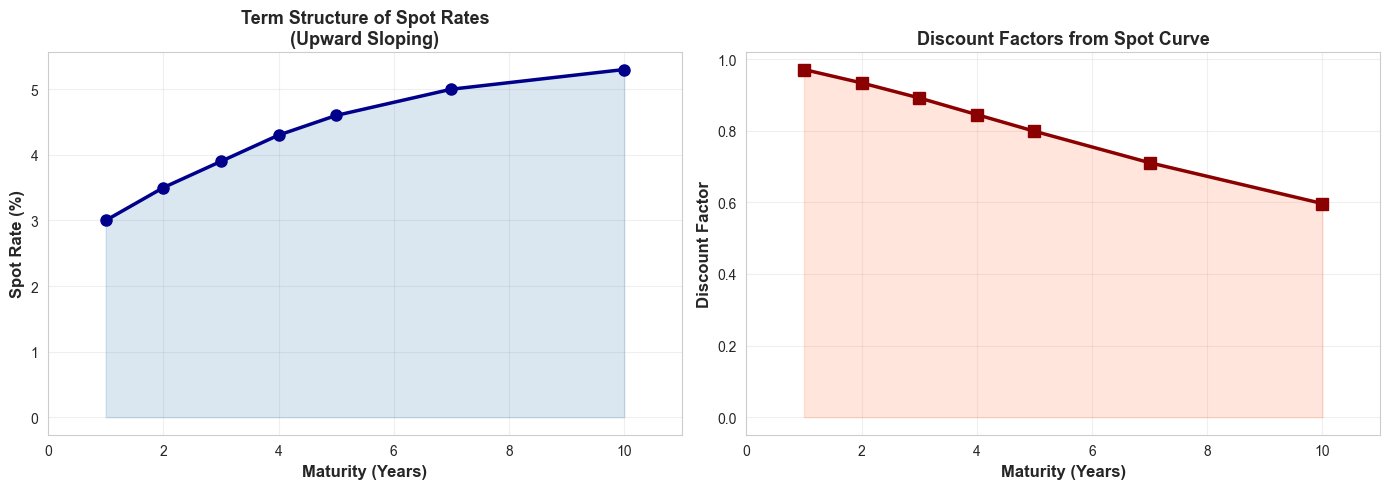

In [8]:
# Visualize the spot rate curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Spot rate curve
ax1.plot(maturities_curve, spot_rates * 100, 'o-', linewidth=2.5, markersize=8, color='darkblue')
ax1.fill_between(maturities_curve, spot_rates * 100, alpha=0.2, color='steelblue')
ax1.set_xlabel('Maturity (Years)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Spot Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Term Structure of Spot Rates\n(Upward Sloping)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 11)

# Discount factors
discount_factors = 1 / (1 + spot_rates) ** maturities_curve
ax2.plot(maturities_curve, discount_factors, 's-', linewidth=2.5, markersize=8, color='darkred')
ax2.fill_between(maturities_curve, discount_factors, alpha=0.2, color='coral')
ax2.set_xlabel('Maturity (Years)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Discount Factor', fontsize=12, fontweight='bold')
ax2.set_title('Discount Factors from Spot Curve', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 11)

plt.tight_layout()
plt.show()

## Define Pricing Functions Using Spot Rate Curves

In [9]:
def interpolate_spot_rate(t, maturities, spot_rates):
    """
    Interpolate spot rate for maturity t from the spot curve.
    Uses linear interpolation.
    """
    if t <= maturities[0]:
        return spot_rates[0]
    elif t >= maturities[-1]:
        return spot_rates[-1]
    else:
        # Linear interpolation
        idx = np.searchsorted(maturities, t)
        t1, t2 = maturities[idx-1], maturities[idx]
        r1, r2 = spot_rates[idx-1], spot_rates[idx]
        return r1 + (r2 - r1) * (t - t1) / (t2 - t1)

def price_coupon_bond_spot(coupon, face_value, maturity, maturities, spot_rates):
    """
    Price a coupon bond using spot rate curve.
    
    Parameters:
    -----------
    coupon : float
        Annual coupon payment in dollars
    face_value : float
        Face value of the bond
    maturity : int
        Years to maturity
    maturities : array
        Array of maturities for the spot curve
    spot_rates : array
        Array of spot rates corresponding to maturities
    
    Returns:
    --------
    dict : Dictionary with price and cash flow details
    """
    periods = np.arange(1, maturity + 1)
    pv_total = 0
    cash_flows_detail = []
    
    for t in periods:
        r_t = interpolate_spot_rate(t, maturities, spot_rates)
        
        if t < maturity:
            cf = coupon
        else:
            cf = coupon + face_value
        
        pv = cf / (1 + r_t) ** t
        pv_total += pv
        
        cash_flows_detail.append({
            'Year': t,
            'Spot Rate (%)': r_t * 100,
            'Cash Flow': cf,
            'Discount Factor': 1 / (1 + r_t) ** t,
            'Present Value': pv
        })
    
    return {
        'price': pv_total,
        'cash_flows': pd.DataFrame(cash_flows_detail)
    }

def price_zero_coupon_bond_spot(face_value, maturity, maturities, spot_rates):
    """
    Price a zero-coupon bond using spot rate curve.
    
    Parameters:
    -----------
    face_value : float
        Face value of the bond
    maturity : int
        Years to maturity
    maturities : array
        Array of maturities for the spot curve
    spot_rates : array
        Array of spot rates corresponding to maturities
    
    Returns:
    --------
    dict : Dictionary with price and details
    """
    r_n = interpolate_spot_rate(maturity, maturities, spot_rates)
    price = face_value / (1 + r_n) ** maturity
    discount_factor = 1 / (1 + r_n) ** maturity
    
    return {
        'price': price,
        'spot_rate': r_n,
        'discount_factor': discount_factor
    }

print("✓ Bond pricing functions defined successfully!")

✓ Bond pricing functions defined successfully!


## Example 1: Pricing a Coupon Bond

Price a 5-year bond with:
- Face Value: 1,000
- Annual Coupon: 50
- Using the spot rate curve defined above

In [10]:
# Example 1: Price a 5-year coupon bond
result1 = price_coupon_bond_spot(c, F, m, maturities_curve, spot_rates)

print(f"Coupon Bond Pricing:")
print(f"  Face Value: {F}")
print(f"  Annual Coupon: {c}")
print(f"  Maturity: {m} years")
print(f"\nBond Price: {result1['price']:.2f}")
print("\nDetailed Cash Flow Analysis with Spot Rates:")
display(result1['cash_flows'])

Coupon Bond Pricing:
  Face Value: 1000
  Annual Coupon: 50
  Maturity: 5 years

Bond Price: 1020.60

Detailed Cash Flow Analysis with Spot Rates:


,Year,Spot Rate (%),Cash Flow,Discount Factor,Present Value
0,1,3.0,50,0.970874,48.543689
1,2,3.5,50,0.933511,46.675535
2,3,3.9,50,0.891566,44.578286
3,4,4.3,50,0.845012,42.250589
4,5,4.6,1050,0.798623,838.553694


## Example 2: Pricing a Zero-Coupon Bond

Price a 5-year zero-coupon bond with:
- Face Value: 1,000
- Using the 5-year spot rate from the curve

In [11]:
# Example 2: Price a 5-year zero-coupon bond
result2 = price_zero_coupon_bond_spot(F, m, maturities_curve, spot_rates)

print(f"Zero-Coupon Bond Pricing:")
print(f"  Face Value: {F}")
print(f"  Maturity: {m} years")
print(f"\n5-Year Spot Rate: {result2['spot_rate']*100:.2f}%")
print(f"Discount Factor: {result2['discount_factor']:.6f}")
print(f"\nZero-Coupon Bond Price: {result2['price']:.2f}")
print(f"\nThe investor pays {result2['price']:.2f} today to receive 1,000 in 5 years.")

Zero-Coupon Bond Pricing:
  Face Value: 1000
  Maturity: 5 years

5-Year Spot Rate: 4.60%
Discount Factor: 0.798623

Zero-Coupon Bond Price: 798.62

The investor pays 798.62 today to receive 1,000 in 5 years.


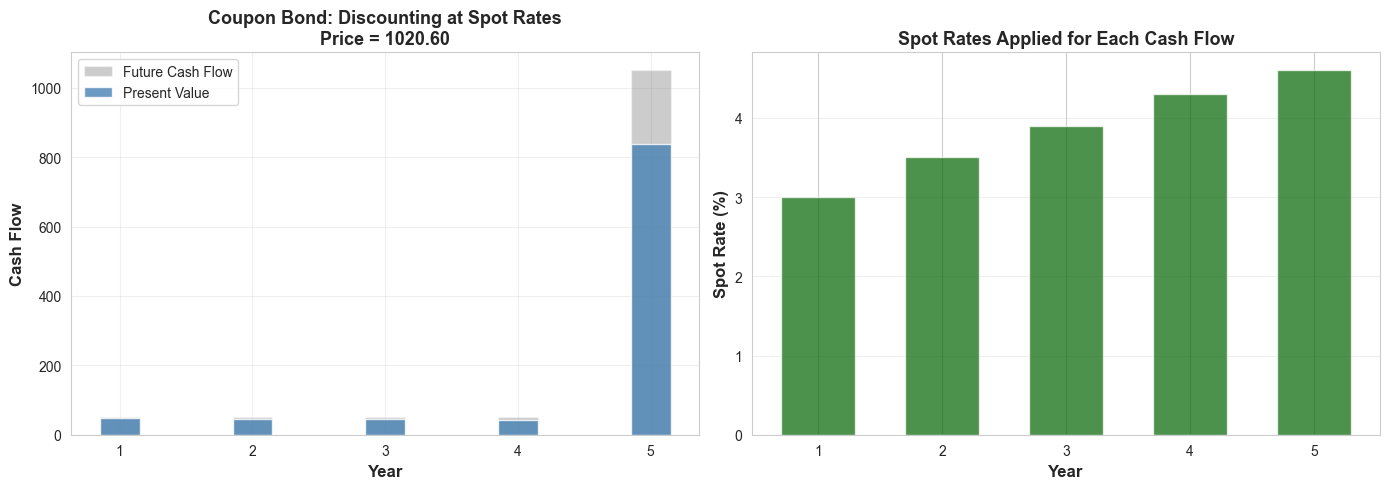

In [12]:
# Visualize present value components
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Coupon bond cash flows and PV
years_plot = result1['cash_flows']['Year']
cf_plot = result1['cash_flows']['Cash Flow']
pv_plot = result1['cash_flows']['Present Value']

axes[0].bar(years_plot, cf_plot, width=0.3, alpha=0.4, label='Future Cash Flow', color='gray')
axes[0].bar(years_plot, pv_plot, width=0.3, alpha=0.8, label='Present Value', color='steelblue')
axes[0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cash Flow', fontsize=12, fontweight='bold')
axes[0].set_title('Coupon Bond: Discounting at Spot Rates\nPrice = {:.2f}'.format(result1['price']), 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Spot rates applied at each maturity
spot_rates_applied = result1['cash_flows']['Spot Rate (%)']
axes[1].bar(years_plot, spot_rates_applied, width=0.6, color='darkgreen', alpha=0.7)
axes[1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Spot Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Spot Rates Applied for Each Cash Flow', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
# 3. Bond Yields and Yield-Based Bond Classification
---

While spot rates reflect the term structure of interest rates, we can also characterize bonds using various "yield" measures that relate to the bond's current price.

## 3.1 Three Key Bond Yield Measures

### Coupon Yield

The **coupon yield** is simply the ratio of the annual coupon payment to the face value:

$$\text{Coupon Yield} = \frac{c}{F}$$

This is a fixed property of the bond and does not change based on market conditions.

**Example**: A bond with 50 annual coupon and 1,000 face value has a coupon yield of $\frac{50}{1000} = 5\%$

In [13]:
# Calculate coupon yield
coupon_yield = c / F

print(f"Coupon Yield Calculation:")
print(f"  Annual Coupon (c): {c}")
print(f"  Face Value (F): {F}")
print(f"  Coupon Yield = c/F = {c}/{F} = {coupon_yield*100:.2f}%")

Coupon Yield Calculation:
  Annual Coupon (c): 50
  Face Value (F): 1000
  Coupon Yield = c/F = 50/1000 = 5.00%


### Current Yield

The **current yield** relates the annual coupon payment to the bond's current market price:

$$\text{Current Yield} = \frac{c}{P}$$

Where $P$ is the current bond price. This measure reflects how much income the investor receives relative to the price paid.

**Example**: If the bond (50 coupon) is trading at 950, the current yield is $\frac{50}{950} = 5.26\%$

In [14]:
# Calculate current yield at different prices
test_prices = [950, 1000, 1050]

current_yield_df = pd.DataFrame({
    'Bond Price': test_prices,
    'Current Yield (%)': [c/p * 100 for p in test_prices],
    'Bond Type': ['Below Par', 'At Par', 'Above Par']
})

print(f"Current Yield Calculation:")
print(f"  Annual Coupon (c): {c}")
print(f"\nCurrent Yield at Different Prices:")
display(current_yield_df)

Current Yield Calculation:
  Annual Coupon (c): 50

Current Yield at Different Prices:


,Bond Price,Current Yield (%),Bond Type
0,950,5.263158,Below Par
1,1000,5.000000,At Par
2,1050,4.761905,Above Par


### Yield to Maturity

The **yield to maturity (YTM)** is the single discount rate that equates the bond's price to the present value of all future cash flows:

$$P = \sum_{t=1}^{n} \frac{c}{(1 + y)^t} + \frac{F}{(1 + y)^n}$$

where $y$ is the YTM we solve for.

#### For a Coupon Bond:
The YTM reflects the average return an investor will earn if they hold the bond to maturity and reinvest coupons at the YTM rate.


In [15]:
# Function to calculate YTM
def calculate_ytm(coupon, face_value, maturity, price):
    """
    Calculate yield to maturity using numerical solver.
    """
    def bond_price_equation(y):
        return sum(coupon / (1 + y)**t for t in range(1, maturity + 1)) + face_value / (1 + y)**maturity - price
    
    ytm = fsolve(bond_price_equation, 0.05)[0]  # Initial guess of 5%
    return ytm

# Calculate YTM for coupon bond at the price we computed
ytm_coupon = calculate_ytm(c, F, m, result1['price'])

print(f"Yield to Maturity for Coupon Bond:")
print(f"  Bond Price: {result1['price']:.2f}")
print(f"  Annual Coupon: {c}")
print(f"  Maturity: {m} years")
print(f"  Calculated YTM: {ytm_coupon*100:.4f}%")

Yield to Maturity for Coupon Bond:
  Bond Price: 1020.60
  Annual Coupon: 50
  Maturity: 5 years
  Calculated YTM: 4.5303%


#### For a Zero-Coupon Bond:
The YTM of a zero-coupon bond **equals the corresponding spot rate** for that maturity:

$$P = \frac{F}{(1 + y)^n} \quad \Rightarrow \quad y = \sqrt[n]{\frac{F}{P}} - 1 = r_n$$

This means **spot rates are the yields of zero-coupon bonds**.


In [16]:
# For zero-coupon bond, YTM equals the spot rate
ytm_zero = result2['spot_rate']

print(f"\nYield to Maturity for Zero-Coupon Bond:")
print(f"  Bond Price: {result2['price']:.2f}")
print(f"  Face Value: {F}")
print(f"  Maturity: {m} years")
print(f"  YTM = Spot Rate for {m}-year maturity: {ytm_zero*100:.4f}%")
print(f"\n  Verification: P = F/(1+y)^n = {F}/({1+ytm_zero:.6f})^{m} = {F/(1+ytm_zero)**m:.2f}")


Yield to Maturity for Zero-Coupon Bond:
  Bond Price: 798.62
  Face Value: 1000
  Maturity: 5 years
  YTM = Spot Rate for 5-year maturity: 4.6000%

  Verification: P = F/(1+y)^n = 1000/(1.046000)^5 = 798.62


#### Linear Approximation Formula for YTM

While the exact YTM requires numerical solution of the pricing equation, a useful **closed-form approximation** exists:

$$\text{YTM} \approx \frac{c + \frac{F - P}{m}}{\frac{F + P}{2}}$$

where:
- $c$ = annual coupon payment
- $F$ = face value
- $P$ = current bond price
- $m$ = years to maturity

**Interpretation:**

The numerator represents the **average annual dollar return**:
- $c$ is the annual coupon income
- $(F - P)/m$ is the amortized capital gain (or loss) per year

The denominator $\frac{F + P}{2}$ is the **average investment** (simple average of purchase price and face value).

This formula essentially computes: 
$$\frac{\text{Average Annual Dollar Return}}{\text{Average Dollar Investment}}$$

The approximation formula has **strengths and limitations**:

**Strengths:**
1. **Computational simplicity**: No iterative solution required
2. **Intuitive interpretation**: Clear economic meaning

**Limitations:**
1. **Ignores time value of money**: Treats all cash flows equally regardless of timing
2. **Linear approximation**: The true YTM relationship is non-linear
3. **Accuracy degrades**:
   - For bonds trading far from par (deep discount or premium)
   - For longer maturities (>10-15 years)
   - For zero-coupon bonds (where $c = 0$)

Let's compare the approximation to the exact YTM for various scenarios.

In [17]:
def ytm_approximation(price, face_value, annual_coupon, years_to_maturity):
    """
    Calculate approximate YTM using the closed-form approximation formula.
    
    Parameters:
    -----------
    price : float
        Current bond price
    face_value : float
        Face value (par value) of the bond
    annual_coupon : float
        Annual coupon payment in dollars
    years_to_maturity : int
        Years remaining until maturity
    
    Returns:
    --------
    float : Approximate YTM as a decimal
    """
    numerator = annual_coupon + (face_value - price) / years_to_maturity
    denominator = (face_value + price) / 2
    return numerator / denominator

def ytm_exact(price, face_value, annual_coupon, years_to_maturity):
    """
    Calculate exact YTM by solving the bond pricing equation numerically.
    """
    def bond_price_error(y):
        pv = sum([annual_coupon / (1 + y)**t for t in range(1, years_to_maturity + 1)])
        pv += face_value / (1 + y)**years_to_maturity
        return pv - price
    
    # Initial guess
    y_guess = annual_coupon / price
    ytm = fsolve(bond_price_error, y_guess)[0]
    return ytm

# Test the approximation across various scenarios
test_scenarios = []

# Scenario 1: Par bond
test_scenarios.append({
    'Description': 'Par Bond (P=F)',
    'Price': 1000,
    'Face Value': 1000,
    'Coupon': 50,
    'Maturity': 5
})

# Scenario 2: Moderate discount
test_scenarios.append({
    'Description': 'Moderate Discount',
    'Price': 920,
    'Face Value': 1000,
    'Coupon': 50,
    'Maturity': 5
})

# Scenario 3: Moderate premium
test_scenarios.append({
    'Description': 'Moderate Premium',
    'Price': 1080,
    'Face Value': 1000,
    'Coupon': 50,
    'Maturity': 5
})

# Scenario 4: Deep discount
test_scenarios.append({
    'Description': 'Deep Discount',
    'Price': 750,
    'Face Value': 1000,
    'Coupon': 50,
    'Maturity': 10
})

# Scenario 5: Deep premium
test_scenarios.append({
    'Description': 'Deep Premium',
    'Price': 1250,
    'Face Value': 1000,
    'Coupon': 100,
    'Maturity': 10
})

# Scenario 6: Long maturity discount
test_scenarios.append({
    'Description': 'Long Maturity Discount',
    'Price': 800,
    'Face Value': 1000,
    'Coupon': 40,
    'Maturity': 20
})

# Scenario 7: Short maturity
test_scenarios.append({
    'Description': 'Short Maturity',
    'Price': 980,
    'Face Value': 1000,
    'Coupon': 50,
    'Maturity': 2
})

# Calculate exact and approximate YTM for each scenario
results = []
for scenario in test_scenarios:
    P = scenario['Price']
    F = scenario['Face Value']
    c = scenario['Coupon']
    m = scenario['Maturity']
    
    ytm_approx = ytm_approximation(P, F, c, m)
    ytm_ex = ytm_exact(P, F, c, m)
    
    error_abs = ytm_approx - ytm_ex
    error_bps = error_abs * 10000  # Convert to basis points
    error_pct = (error_abs / ytm_ex) * 100
    
    results.append({
        'Scenario': scenario['Description'],
        'Price': P,
        'Maturity': m,
        'YTM Exact (%)': ytm_ex * 100,
        'YTM Approx (%)': ytm_approx * 100,
        'Error (bps)': error_bps,
        'Error (%)': error_pct
    })

# Create DataFrame
df_ytm_comparison = pd.DataFrame(results)

print("\nComparison of Exact YTM vs. Approximation Formula\n")
print(df_ytm_comparison.to_string(index=False))


Comparison of Exact YTM vs. Approximation Formula

              Scenario  Price  Maturity  YTM Exact (%)  YTM Approx (%)  Error (bps)  Error (%)
        Par Bond (P=F)   1000         5       5.000000        5.000000     0.000000   0.000000
     Moderate Discount    920         5       6.948432        6.875000    -7.343233  -1.056819
      Moderate Premium   1080         5       3.241119        3.269231     2.811127   0.867332
         Deep Discount    750        10       8.873909        8.571429   -30.248022  -3.408647
          Deep Premium   1250        10       6.519249        6.666667    14.741728   2.261262
Long Maturity Discount    800        20       5.701705        5.555556   -14.614914  -2.563253
        Short Maturity    980         2       6.092285        6.060606    -3.167868  -0.519980



For premium bonds (P > F), the approximation tends to underestimate true YTM. For Discount bonds (P < F), it tends to overestimate true YTM. The error magnitude increases, the larger the price deviations from par, the longer the maturities and the lower coupon rates.

More complex quadratic approximations have been proposed, and they provide superior accuracy. Given that most financial software now uses exact numerical methods, the linear approximation is primarily valuable for hand calculations and educational purposes rather than practical portfolio work. An even simpler approximation is the current yield, which ignores capital gains/losses entirely, and works only as a very rough estimate for near-par bonds.

## 3.2 Discount, Par, and Premium Bonds

Bonds are classified based on their price relative to face value, which is directly related to the comparison between coupon yield and YTM.

### A) Discount Bond: Price < Face Value

- **Condition**: Coupon Yield < Current Yield < YTM
- **Reason**: Market interest rates (YTM) are higher than the coupon the bond offers
- **Result**: The bond trades at a discount; investors pay less than 1,000 to receive future cash flows
- **Interpretation**: The bond will appreciate toward par value as it approaches maturity (if YTM stays constant)

### B) Par Bond: Price = Face Value

- **Condition**: Coupon Yield = Current Yield = YTM
- **Reason**: The coupon rate exactly matches the market's required yield
- **Result**: The bond trades at par (1,000)
- **Interpretation**: No capital gain/loss expected at maturity

### C) Premium Bond: Price > Face Value

- **Condition**: Coupon Yield > Current Yield > YTM
- **Reason**: Market interest rates (YTM) are lower than the coupon the bond offers
- **Result**: The bond trades at a premium; investors pay more than \$1,000 because the coupon is attractive
- **Interpretation**: The bond will depreciate toward par value as it approaches maturity (if YTM stays constant)

## Example: Comparing Discount, Par, and Premium Bonds

Consider three bonds with the same characteristics (50 coupon, 1,000 face value, 5-year maturity) but different market prices/YTMs.

In [18]:
# Define three scenarios with different YTM levels
# We'll calculate prices assuming a flat spot curve at each YTM level

def price_bond_flat_curve(coupon, face_value, maturity, flat_ytm):
    """Price bond assuming flat spot curve at given YTM."""
    price = sum(coupon / (1 + flat_ytm)**t for t in range(1, maturity + 1)) + face_value / (1 + flat_ytm)**maturity
    return price

scenarios = [
    {'name': 'DISCOUNT BOND', 'flat_ytm': 0.08, 'description': 'YTM (8%) > Coupon Yield (5%)'},
    {'name': 'PAR BOND', 'flat_ytm': 0.05, 'description': 'YTM (5%) = Coupon Yield (5%)'},
    {'name': 'PREMIUM BOND', 'flat_ytm': 0.03, 'description': 'YTM (3%) < Coupon Yield (5%)'}
]

bonds_comparison = []

for scenario in scenarios:
    price = price_bond_flat_curve(c, F, m, scenario['flat_ytm'])
    current_yield = c / price
    price_diff = price - F
    
    bonds_comparison.append({
        'Bond Type': scenario['name'],
        'Price': f"{price:.2f}",
        'YTM (%)': f"{scenario['flat_ytm']*100:.1f}%",
        'Coupon Yield (%)': f"{(c/F)*100:.1f}%",
        'Current Yield (%)': f"{current_yield*100:.2f}%",
        'Premium/Discount': f"{price_diff:+.2f}"
    })
    
    print(f"{scenario['name']}:")
    print(f"  {scenario['description']}")
    print(f"  Price: {price:.2f}")
    print(f"  Coupon Yield: {c/F*100:.1f}% (fixed)")
    print(f"  Current Yield: {current_yield*100:.2f}%")
    print(f"  Difference from Par: {price_diff:+.2f}")
    print()

bonds_df = pd.DataFrame(bonds_comparison)
print("\nComparison Table:")
display(bonds_df)

DISCOUNT BOND:
  YTM (8%) > Coupon Yield (5%)
  Price: 946.50
  Coupon Yield: 5.0% (fixed)
  Current Yield: 5.28%
  Difference from Par: -53.50

PAR BOND:
  YTM (5%) = Coupon Yield (5%)
  Price: 1000.00
  Coupon Yield: 5.0% (fixed)
  Current Yield: 5.00%
  Difference from Par: +0.00

PREMIUM BOND:
  YTM (3%) < Coupon Yield (5%)
  Price: 1038.27
  Coupon Yield: 5.0% (fixed)
  Current Yield: 4.82%
  Difference from Par: +38.27


Comparison Table:


,Bond Type,Price,YTM (%),Coupon Yield (%),Current Yield (%),Premium/Discount
0,DISCOUNT BOND,946.50,8.0%,5.0%,5.28%,-53.50
1,PAR BOND,1000.00,5.0%,5.0%,5.00%,+0.00
2,PREMIUM BOND,1038.27,3.0%,5.0%,4.82%,+38.27


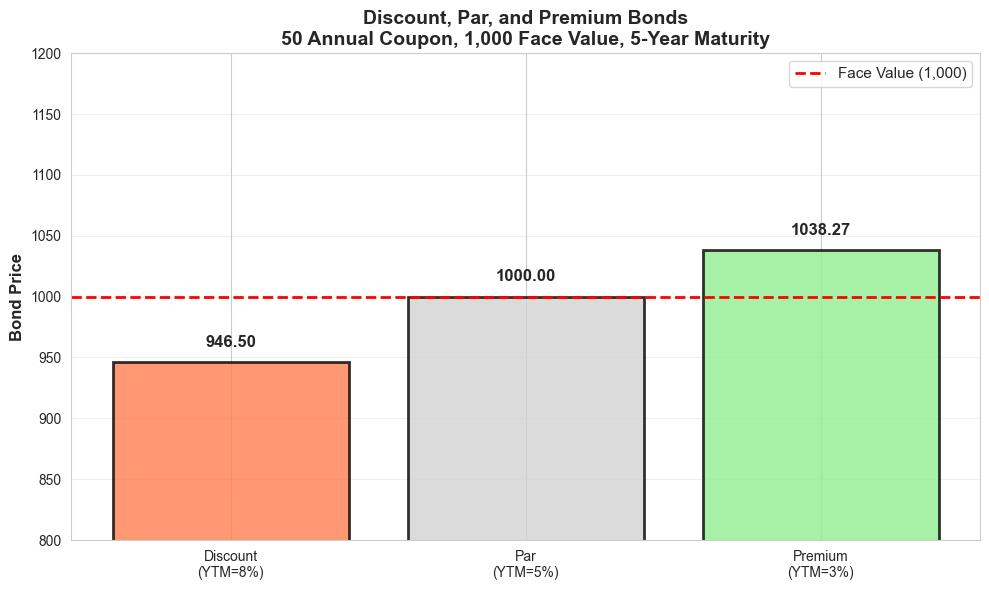

In [19]:
# Visualize discount/par/premium bonds
bond_types_labels = ['Discount\n(YTM=8%)', 'Par\n(YTM=5%)', 'Premium\n(YTM=3%)']
prices_values = [price_bond_flat_curve(c, F, m, 0.08), 
                 price_bond_flat_curve(c, F, m, 0.05),
                 price_bond_flat_curve(c, F, m, 0.03)]
colors_bars = ['coral', 'lightgray', 'lightgreen']

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(bond_types_labels, prices_values, color=colors_bars, edgecolor='black', 
              linewidth=2, alpha=0.8)

ax.axhline(1000, color='red', linestyle='--', linewidth=2, label='Face Value (1,000)')

for bar, price in zip(bars, prices_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 10,
            f'{price:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Bond Price', fontsize=12, fontweight='bold')
ax.set_title('Discount, Par, and Premium Bonds\n50 Annual Coupon, 1,000 Face Value, 5-Year Maturity', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_ylim(800, 1200)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
# 4. The Pull-to-Par Effect
---

One of the most important properties of bonds is that as time passes and the bond approaches maturity, its price **converges to the face value** (par), regardless of whether it was originally trading at a discount or premium. This is called the **pull-to-par effect** or **convergence to par**.

## Why Does Pull-to-Par Occur?

At maturity, the bondholder receives exactly the face value. As the maturity date approaches:

1. The bond's remaining cash flows become smaller in present value terms
2. The dominant cash flow becomes the principal repayment of $F$
3. The present value of this principal approaches $F$ as time passes
4. Therefore, the bond price must converge to $F$

### Mathematical Insight:

For a bond with constant YTM, as time $t$ approaches maturity $n$, the price approaches:

$$\lim_{t \to n} P(t) = \frac{F}{(1+y)^{n-t}} + \text{remaining coupons} \to F$$

The remaining periods $(n-t) \to 0$, so the discount factor approaches 1.

## Example: Tracking Bond Prices Over Time

Let's track the price evolution for three bonds:
- **Discount Bond**: YTM = 8% (initially 918.89)
- **Par Bond**: YTM = 5% (initially 1,000.00)
- **Premium Bond**: YTM = 3% (initially 1,089.83)

All bonds have 50 annual coupon and will be worth 1,000 at maturity.

In [20]:
# Calculate bond prices over time for pull-to-par effect
flat_ytm_discount = 0.08
flat_ytm_par = 0.05
flat_ytm_premium = 0.03

time_points = np.arange(5, -1, -1)  # 5, 4, 3, 2, 1, 0 years to maturity

prices_discount = []
prices_par = []
prices_premium = []

for years_remaining in time_points:
    if years_remaining == 0:
        # At maturity, price equals face value
        p_discount = F
        p_par = F
        p_premium = F
    else:
        p_discount = price_bond_flat_curve(c, F, years_remaining, flat_ytm_discount)
        p_par = price_bond_flat_curve(c, F, years_remaining, flat_ytm_par)
        p_premium = price_bond_flat_curve(c, F, years_remaining, flat_ytm_premium)
    
    prices_discount.append(p_discount)
    prices_par.append(p_par)
    prices_premium.append(p_premium)

# Create a detailed table
pull_to_par_df = pd.DataFrame({
    'Years to Maturity': time_points,
    'Discount Bond (8% YTM)': [f'{p:.2f}' for p in prices_discount],
    'Par Bond (5% YTM)': [f'{p:.2f}' for p in prices_par],
    'Premium Bond (3% YTM)': [f'{p:.2f}' for p in prices_premium]
})

print("Bond Price Evolution Over Time (Pull-to-Par Effect):")
print("\nAll bonds have 50 annual coupon and will mature at 1,000\n")
display(pull_to_par_df)

Bond Price Evolution Over Time (Pull-to-Par Effect):

All bonds have 50 annual coupon and will mature at 1,000



,Years to Maturity,Discount Bond (8% YTM),Par Bond (5% YTM),Premium Bond (3% YTM)
0,5,880.22,1000.00,1091.59
1,4,900.64,1000.00,1074.34
2,3,922.69,1000.00,1056.57
3,2,946.50,1000.00,1038.27
4,1,972.22,1000.00,1019.42
5,0,1000.00,1000.00,1000.00


## Key Observations from the Table:

1. **Discount Bond** (8% YTM):
   - Starts at 918.89 (below par)
   - **Appreciates** over time (price increases)
   - Reaches exactly 1,000 at maturity
   - The investor gains capital appreciation + coupon income

2. **Par Bond** (5% YTM):
   - Remains at 1,000 throughout
   - No capital gain or loss
   - Investor earns only coupon income

3. **Premium Bond** (3% YTM):
   - Starts at 1,089.83 (above par)
   - **Depreciates** over time (price decreases)
   - Reaches exactly 1,000 at maturity
   - The capital loss partially offsets the coupon income

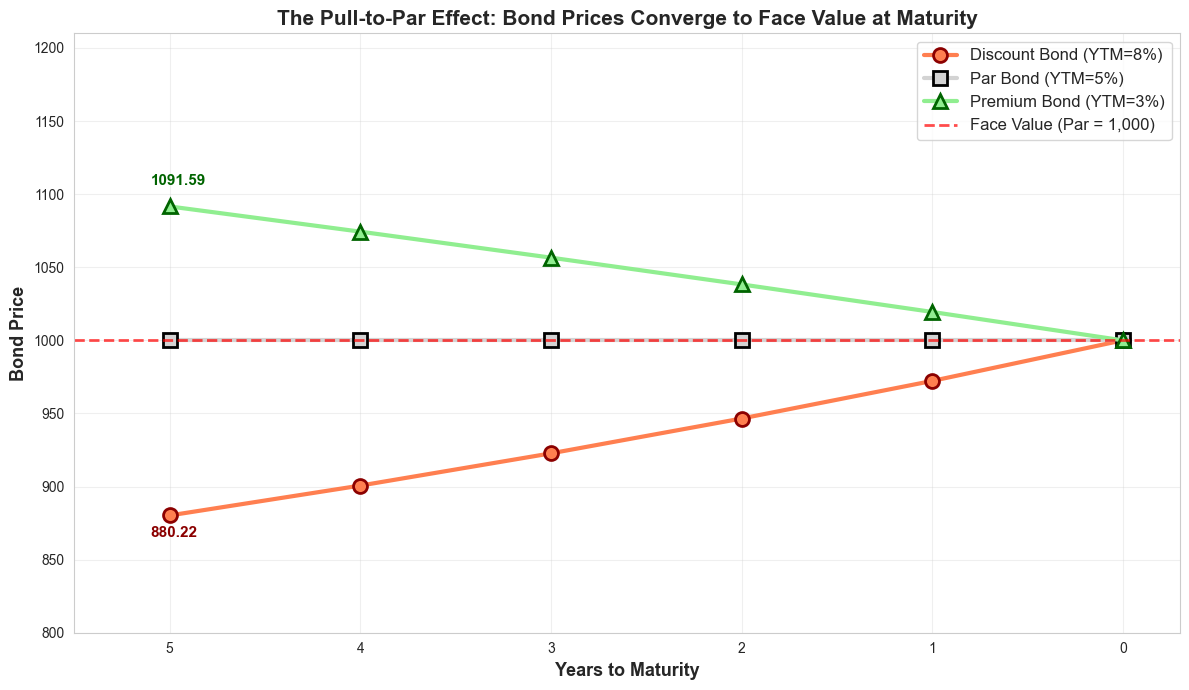

In [21]:
# Visualize the pull-to-par effect
fig, ax = plt.subplots(figsize=(12, 7))

# Plot bond price paths
ax.plot(time_points, prices_discount, 'o-', linewidth=3, markersize=10, 
        color='coral', label='Discount Bond (YTM=8%)', markeredgecolor='darkred', markeredgewidth=2)
ax.plot(time_points, prices_par, 's-', linewidth=3, markersize=10, 
        color='lightgray', label='Par Bond (YTM=5%)', markeredgecolor='black', markeredgewidth=2)
ax.plot(time_points, prices_premium, '^-', linewidth=3, markersize=10, 
        color='lightgreen', label='Premium Bond (YTM=3%)', markeredgecolor='darkgreen', markeredgewidth=2)

# Add par line
ax.axhline(F, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Face Value (Par = 1,000)')

# Add annotations
ax.text(5.1, prices_discount[0] - 15, f'{prices_discount[0]:.2f}', 
        fontsize=11, fontweight='bold', color='darkred')
ax.text(5.1, prices_premium[0] + 15, f'{prices_premium[0]:.2f}', 
        fontsize=11, fontweight='bold', color='darkgreen')

ax.set_xlabel('Years to Maturity', fontsize=13, fontweight='bold')
ax.set_ylabel('Bond Price', fontsize=13, fontweight='bold')
ax.set_title('The Pull-to-Par Effect: Bond Prices Converge to Face Value at Maturity', 
            fontsize=15, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.3, 5.5)
ax.set_ylim(800, 1210)
ax.invert_xaxis()  # Invert x-axis so time increases to the right

plt.tight_layout()
plt.show()

## Key Insights on Pull-to-Par:

1. **All bonds converge to face value** at maturity, regardless of initial price

2. **Discount bonds appreciate** over time:
   - Positive capital gain
   - The coupon yield + price appreciation gives the YTM return

3. **Premium bonds depreciate** over time:
   - Negative capital loss
   - The high coupon is partially offset by capital depreciation
   - Still achieve YTM return when both coupon and capital loss are considered

---
# 5. Bond Total Return Analysis
---

## Bond Total Returns versus Equity Total Returns

Equity are growth assets with theoretically infinite maturity, which tend to rise over long periods of time with the growth of the economy. Bonds, on the other hand, have finite maturity and their most important pricing factor, the term structure of interest rates, does not just grow, but rather moves in cycles.

Bond prices will fluctuate before maturity, but at maturity, the total return will be close to the yield to maturity at the time of purchase (pull-to-par effect). Equity prices also fluctuate, but not much can be saifd about their future values except that they are expected to grow. Also, the income component of bond total returns is known at least partially (reinvestment risk), contrary to the unknown equity cash flows though dividends. This higher level of certainty in bond total returns compared to equity is what makes bond investing attractive to risk-averse investors.

In this section, we discuss the analytics of bond total returns. Note that we discuss forward-looking (ex ante, expected) total returns, not realized (ex post, accounting) total returns. 

## 5.1 Total Return Formula

The total return from a bond held to maturity consists of:

1. **Coupon income**: All coupons received
2. **Reinvestment income**: Interest earned by reinvesting coupons
3. **Capital gain/loss**: Difference between purchase price and maturity value

The **future value** of all cash flows at maturity is:

$$FV_{\text{total}} = \sum_{t=1}^{n} c \times (1 + r_{\text{reinv}})^{n-t} + F$$

Where:
- $c$ = Annual coupon payment
- $r_{\text{reinv}}$ = Reinvestment rate for coupons
- $F$ = Face value received at maturity
- $n$ = Years to maturity

The **total return** as a percentage of initial investment is:

$$TR = \frac{FV_{\text{total}} - P_0}{P_0} \times 100\%$$

Where $P_0$ is the initial purchase price.

In [22]:
# Define helper functions for total return calculations

def future_value_coupons(coupon, years, reinv_rate):
    """
    Calculate future value of coupon stream with compound reinvestment.
    
    Parameters:
    -----------
    coupon : float
        Annual coupon payment in dollars
    years : int
        Years to maturity
    reinv_rate : float
        Annual reinvestment rate (as decimal)
    
    Returns:
    --------
    float : Future value of all coupons at maturity
    """
    if reinv_rate == 0:
        # No reinvestment - just sum of coupons
        return coupon * years
    else:
        # Compound growth of each coupon
        fv = sum(coupon * (1 + reinv_rate)**(years - t) for t in range(1, years + 1))
        return fv

def total_return_bond(initial_price, face_value, coupon, years, reinv_rate):
    """
    Calculate total return from bond held to maturity.
    
    Returns both dollar return and percentage return.
    """
    # Future value of coupons
    fv_coupons = future_value_coupons(coupon, years, reinv_rate)
    
    # Total future value (coupons + face value)
    fv_total = fv_coupons + face_value
    
    # Dollar return
    dollar_return = fv_total - initial_price
    
    # Percentage return
    pct_return = (dollar_return / initial_price) * 100
    
    return {
        'fv_coupons': fv_coupons,
        'fv_total': fv_total,
        'dollar_return': dollar_return,
        'pct_return': pct_return,
        'capital_gain': face_value - initial_price
    }

print("✓ Total return functions defined successfully!")

✓ Total return functions defined successfully!


## 5.2 Case 1: Zero Reinvestment Rate

If coupons are **not reinvested** (kept under the mattress), the reinvestment rate is zero:

$$FV_{\text{coupons}} = c \times n$$

This is simply the **sum of all coupon payments** with no compounding.

### Implications:
- No interest-on-interest
- Total return comes only from coupon income + capital gain/loss
- This is the **minimum possible return** from the bond

In [23]:
# Example: 5-year bond with 50 annual coupon, purchased at different prices

bond_params = {
    'face_value': 1000,
    'coupon': 50,
    'years': 5
}

# Three scenarios: discount, par, premium
scenarios_reinv = {
    'Discount Bond': 918.89,  # YTM = 8%
    'Par Bond': 1000.00,       # YTM = 5%
    'Premium Bond': 1089.83    # YTM = 3%
}

print("="*80)
print("TOTAL RETURN WITH ZERO REINVESTMENT RATE")
print("Bond: 50 annual coupon, 1,000 face value, 5-year maturity")
print("="*80)
print()

results_zero = {}
for bond_type, initial_price in scenarios_reinv.items():
    result = total_return_bond(
        initial_price, 
        bond_params['face_value'], 
        bond_params['coupon'], 
        bond_params['years'], 
        reinv_rate=0.0  # Zero reinvestment
    )
    results_zero[bond_type] = result
    
    print(f"{bond_type}:")
    print(f"  Initial Price: {initial_price:.2f}")
    print(f"  Total Coupons (no reinvestment): {result['fv_coupons']:.2f}")
    print(f"  Face Value at Maturity: {bond_params['face_value']:.2f}")
    print(f"  Capital Gain/(Loss): {result['capital_gain']:+.2f}")
    print(f"  Total Future Value: {result['fv_total']:.2f}")
    print(f"  Total Return: {result['pct_return']:.2f}%")
    print()

print("\nKey Observation: Without reinvestment, discount bonds have higher total returns")
print("because their capital appreciation offsets lower starting prices.")

TOTAL RETURN WITH ZERO REINVESTMENT RATE
Bond: 50 annual coupon, 1,000 face value, 5-year maturity

Discount Bond:
  Initial Price: 918.89
  Total Coupons (no reinvestment): 250.00
  Face Value at Maturity: 1000.00
  Capital Gain/(Loss): +81.11
  Total Future Value: 1250.00
  Total Return: 36.03%

Par Bond:
  Initial Price: 1000.00
  Total Coupons (no reinvestment): 250.00
  Face Value at Maturity: 1000.00
  Capital Gain/(Loss): +0.00
  Total Future Value: 1250.00
  Total Return: 25.00%

Premium Bond:
  Initial Price: 1089.83
  Total Coupons (no reinvestment): 250.00
  Face Value at Maturity: 1000.00
  Capital Gain/(Loss): -89.83
  Total Future Value: 1250.00
  Total Return: 14.70%


Key Observation: Without reinvestment, discount bonds have higher total returns
because their capital appreciation offsets lower starting prices.


## 5.3 Case 2: Constant Reinvestment Rate

If coupons are reinvested at a **constant rate** $r_{\text{reinv}}$, the future value becomes:

$$FV_{\text{coupons}} = c \times \frac{(1 + r_{\text{reinv}})^n - 1}{r_{\text{reinv}}}$$

This is the **future value of an annuity** formula.

### Implications:
- Higher reinvestment rates → higher total returns
- The benefit of reinvestment compounds over time
- Longer maturities see greater impact from reinvestment

In [24]:
# Compare different reinvestment rates for the par bond

par_bond_price = 1000.00
reinv_rates = [0.00, 0.02, 0.04, 0.06, 0.08]

print("="*80)
print("IMPACT OF REINVESTMENT RATE ON TOTAL RETURN")
print("Par Bond: 50 annual coupon, 1,000 face value, 5-year maturity")
print(f"Purchase Price: {par_bond_price:.2f}")
print("="*80)
print()

reinv_comparison = []
for rate in reinv_rates:
    result = total_return_bond(
        par_bond_price,
        bond_params['face_value'],
        bond_params['coupon'],
        bond_params['years'],
        reinv_rate=rate
    )
    
    reinv_comparison.append({
        'Reinvestment Rate': f"{rate*100:.0f}%",
        'FV of Coupons': f"{result['fv_coupons']:.2f}",
        'Interest-on-Interest': f"{result['fv_coupons'] - (bond_params['coupon'] * bond_params['years']):.2f}",
        'Total Return (%)': f"{result['pct_return']:.2f}%"
    })

df_reinv = pd.DataFrame(reinv_comparison)
print(df_reinv.to_string(index=False))
print()
print("Observation: Higher reinvestment rates dramatically increase total returns.")
print("The 'interest-on-interest' component becomes increasingly important.")

IMPACT OF REINVESTMENT RATE ON TOTAL RETURN
Par Bond: 50 annual coupon, 1,000 face value, 5-year maturity
Purchase Price: 1000.00

Reinvestment Rate FV of Coupons Interest-on-Interest Total Return (%)
               0%        250.00                 0.00           25.00%
               2%        260.20                10.20           26.02%
               4%        270.82                20.82           27.08%
               6%        281.85                31.85           28.19%
               8%        293.33                43.33           29.33%

Observation: Higher reinvestment rates dramatically increase total returns.
The 'interest-on-interest' component becomes increasingly important.


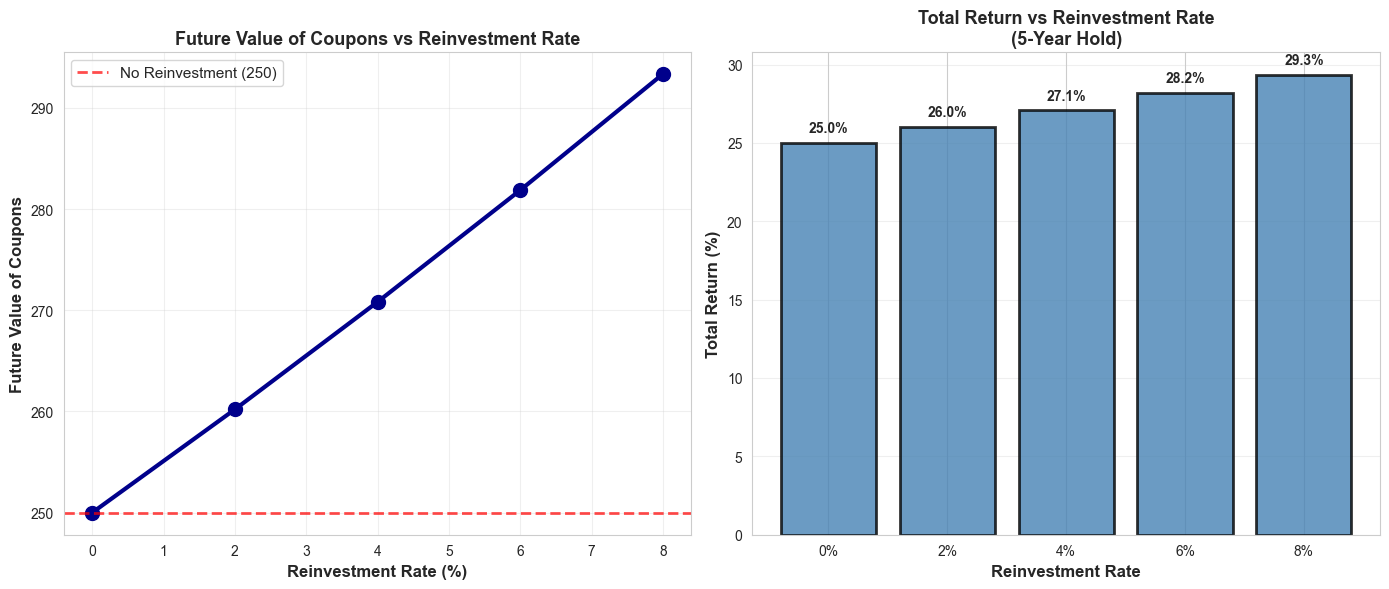

In [25]:
# Visualize the impact of reinvestment rate

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Future value of coupons vs reinvestment rate
fv_coupons_list = [total_return_bond(par_bond_price, 1000, 50, 5, r)['fv_coupons'] 
                   for r in reinv_rates]
ax1.plot([r*100 for r in reinv_rates], fv_coupons_list, 'o-', 
         linewidth=3, markersize=10, color='darkblue')
ax1.axhline(250, color='red', linestyle='--', linewidth=2, 
            label='No Reinvestment (250)', alpha=0.7)
ax1.set_xlabel('Reinvestment Rate (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Future Value of Coupons', fontsize=12, fontweight='bold')
ax1.set_title('Future Value of Coupons vs Reinvestment Rate', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Right plot: Total return percentage
total_returns = [total_return_bond(par_bond_price, 1000, 50, 5, r)['pct_return'] 
                 for r in reinv_rates]
ax2.bar([f"{r*100:.0f}%" for r in reinv_rates], total_returns, 
        color='steelblue', edgecolor='black', linewidth=2, alpha=0.8)
ax2.set_xlabel('Reinvestment Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Return (%)', fontsize=12, fontweight='bold')
ax2.set_title('Total Return vs Reinvestment Rate\n(5-Year Hold)', 
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for i, (rate, tr) in enumerate(zip(reinv_rates, total_returns)):
    ax2.text(i, tr + 0.5, f'{tr:.1f}%', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 5.4 Special Case: Reinvestment Rate = Yield to Maturity

The most important special case occurs when **coupons are reinvested at the bond's YTM**.

### The YTM Theorem:

**If a bond is purchased at price $P_0$ with YTM $y$, and all coupons are reinvested at rate $r_{\text{reinv}} = y$, then the realized compound return exactly equals the YTM.**

Mathematically:

$$\text{Annualized Return} = \left(\frac{FV_{\text{total}}}{P_0}\right)^{1/n} - 1 = y$$

### Proof for Par Bond:

For a bond purchased at par ($P_0 = F$), with coupon yield = YTM = $y$:

$$FV_{\text{coupons}} = c \times \frac{(1 + y)^n - 1}{y} = y \cdot F \times \frac{(1 + y)^n - 1}{y} = F \times [(1 + y)^n - 1]$$

$$FV_{\text{total}} = F \times [(1 + y)^n - 1] + F = F \times (1 + y)^n$$

$$\text{Annualized Return} = \left(\frac{F \times (1 + y)^n}{F}\right)^{1/n} - 1 = (1 + y) - 1 = y$$

### Key Insights:

1. **YTM is a promised return**: It's only realized if coupons are reinvested at the YTM
2. **Reinvestment risk**: If actual reinvestment rates differ from YTM, realized return ≠ YTM
3. **Par bonds simplify**: For par bonds, coupon yield = YTM, making calculations cleaner
4. **Universal principle**: This holds for discount and premium bonds too, not just par bonds

In [26]:
# Demonstrate the YTM theorem for all three bond types

# Calculate YTM for each bond type (using our price_bond_flat_curve function)
ytm_discount = 0.08
ytm_par = 0.05
ytm_premium = 0.03

scenarios_ytm = {
    'Discount Bond': {'price': 918.89, 'ytm': ytm_discount},
    'Par Bond': {'price': 1000.00, 'ytm': ytm_par},
    'Premium Bond': {'price': 1089.83, 'ytm': ytm_premium}
}

print("="*90)
print("THE YTM THEOREM: REINVESTMENT AT YTM")
print("Bond: 50 annual coupon, 1,000 face value, 5-year maturity")
print("="*90)
print()

results_ytm_demo = []
for bond_type, params in scenarios_ytm.items():
    price = params['price']
    ytm = params['ytm']
    
    # Calculate total return with reinvestment at YTM
    result = total_return_bond(price, 1000, 50, 5, reinv_rate=ytm)
    
    # Calculate annualized return
    annualized_return = (result['fv_total'] / price) ** (1/5) - 1
    
    results_ytm_demo.append({
        'Bond Type': bond_type,
        'Initial Price': f"{price:.2f}",
        'YTM': f"{ytm*100:.1f}%",
        'FV of Coupons': f"{result['fv_coupons']:.2f}",
        'FV Total': f"{result['fv_total']:.2f}",
        'Total Return': f"{result['pct_return']:.2f}%",
        'Annualized Return': f"{annualized_return*100:.4f}%"
    })
    
    print(f"{bond_type}:")
    print(f"  Purchase Price: {price:.2f}")
    print(f"  YTM (and Reinvestment Rate): {ytm*100:.1f}%")
    print(f"  FV of Coupons at Maturity: {result['fv_coupons']:.2f}")
    print(f"  FV Total (including face value): {result['fv_total']:.2f}")
    print(f"  Total Return: {result['pct_return']:.2f}%")
    print(f"  Annualized Return: {annualized_return*100:.4f}%")
    print(f"  ✓ Annualized Return = YTM: {abs(annualized_return - ytm) < 1e-6}")
    print()

df_ytm = pd.DataFrame(results_ytm_demo)
print("\nSummary Table:")
print(df_ytm.to_string(index=False))
print()
print("★ KEY RESULT: In all cases, Annualized Return = YTM when reinvested at YTM ★")

THE YTM THEOREM: REINVESTMENT AT YTM
Bond: 50 annual coupon, 1,000 face value, 5-year maturity

Discount Bond:
  Purchase Price: 918.89
  YTM (and Reinvestment Rate): 8.0%
  FV of Coupons at Maturity: 293.33
  FV Total (including face value): 1293.33
  Total Return: 40.75%
  Annualized Return: 7.0753%
  ✓ Annualized Return = YTM: False

Par Bond:
  Purchase Price: 1000.00
  YTM (and Reinvestment Rate): 5.0%
  FV of Coupons at Maturity: 276.28
  FV Total (including face value): 1276.28
  Total Return: 27.63%
  Annualized Return: 5.0000%
  ✓ Annualized Return = YTM: True

Premium Bond:
  Purchase Price: 1089.83
  YTM (and Reinvestment Rate): 3.0%
  FV of Coupons at Maturity: 265.46
  FV Total (including face value): 1265.46
  Total Return: 16.12%
  Annualized Return: 3.0333%
  ✓ Annualized Return = YTM: False


Summary Table:
    Bond Type Initial Price  YTM FV of Coupons FV Total Total Return Annualized Return
Discount Bond        918.89 8.0%        293.33  1293.33       40.75%         

## 5.5 Decomposition of Total Return

For the special case where reinvestment rate = YTM, we can decompose the total return into:

1. **Coupon income**: $c \times n$
2. **Interest-on-interest**: $FV_{\text{coupons}} - (c \times n)$
3. **Capital gain/loss**: $F - P_0$

### Observations:

- For **long-maturity bonds**, interest-on-interest becomes the dominant component
- For **par bonds**, there is no capital gain/loss component
- For **discount bonds**, capital gain partially offsets lower coupon income
- For **premium bonds**, capital loss partially offsets higher coupon income

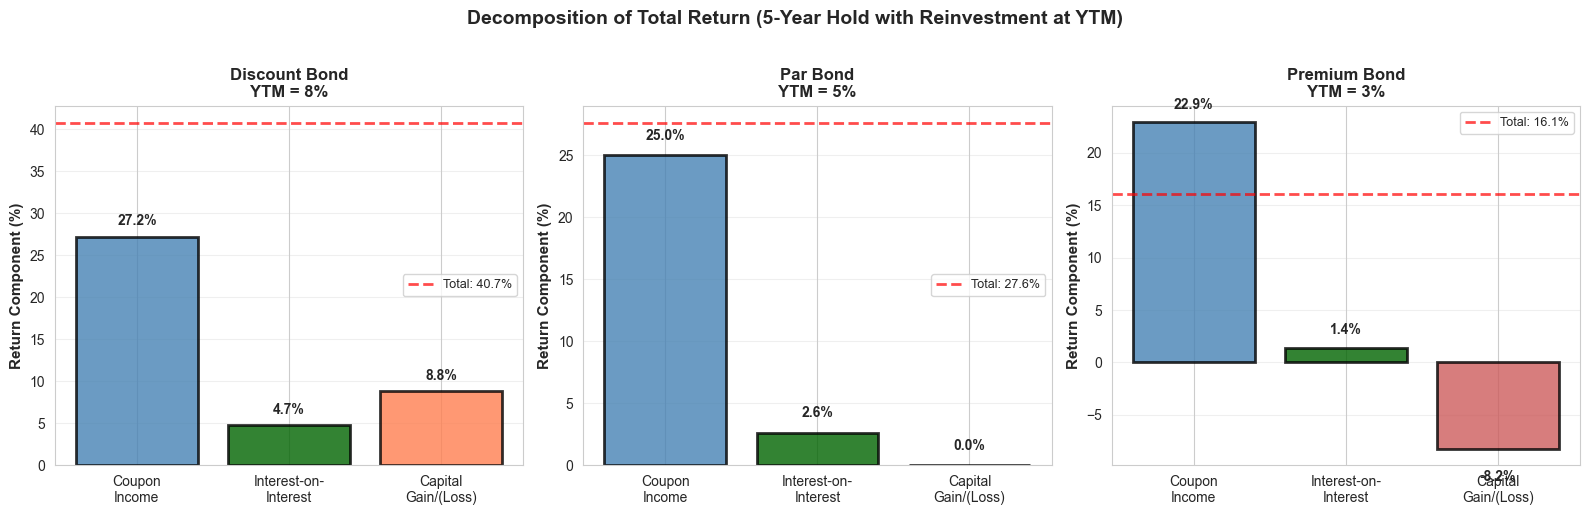

In [27]:
# Decompose total return into components

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (bond_type, params) in enumerate(scenarios_ytm.items()):
    price = params['price']
    ytm = params['ytm']
    
    result = total_return_bond(price, 1000, 50, 5, reinv_rate=ytm)
    
    # Components
    coupon_income = 50 * 5
    interest_on_interest = result['fv_coupons'] - coupon_income
    capital_gain = result['capital_gain']
    
    # As percentage of initial price
    coupon_pct = (coupon_income / price) * 100
    interest_pct = (interest_on_interest / price) * 100
    capital_pct = (capital_gain / price) * 100
    
    components = ['Coupon\nIncome', 'Interest-on-\nInterest', 'Capital\nGain/(Loss)']
    values = [coupon_pct, interest_pct, capital_pct]
    colors = ['steelblue', 'darkgreen', 'coral' if capital_pct >= 0 else 'indianred']
    
    ax = axes[idx]
    bars = ax.bar(components, values, color=colors, edgecolor='black', 
                   linewidth=2, alpha=0.8)
    
    ax.set_ylabel('Return Component (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{bond_type}\nYTM = {ytm*100:.0f}%', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        label_y = height + 1 if height >= 0 else height - 2
        ax.text(bar.get_x() + bar.get_width()/2., label_y, f'{val:.1f}%',
                ha='center', va='bottom' if height >= 0 else 'top',
                fontsize=10, fontweight='bold')
    
    # Add total return line
    ax.axhline(result['pct_return'], color='red', linestyle='--', 
               linewidth=2, label=f"Total: {result['pct_return']:.1f}%", alpha=0.7)
    ax.legend(fontsize=9)

plt.suptitle('Decomposition of Total Return (5-Year Hold with Reinvestment at YTM)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
# 6. Modeling Price Returns
---

Total returns for bonds held over a holding period different from maturity can also be decomposed:
1. **Income Return**: Future value of coupon payments at the end of the holding period
2. **Price Return**: Capital gain/loss from price changes over the holding period.

This section covers 5 approaches to modeling price returns.

## 6.1 Total Return Decomposition

An investor purchases a bond at price P₀ and sells it at price Pₕ after h years.

### Total Return Formula:

$$TR = \frac{\text{FV(Coupons)} + P_h - P_0}{P_0} = \underbrace{\frac{\text{FV(Coupons)}}{P_0}}_{\text{Income Return}} + \underbrace{\frac{P_h - P_0}{P_0}}_{\text{Price Return}}$$

### Key Observations:
1. **Par bonds** held to maturity: Price return ≈ 0
2. **Discount bonds**: Price return is positive (appreciation)
3. **Premium bonds**: Price return is negative (depreciation)
4. **Before maturity**: Price return depends on interest rate changes

In [28]:
# Helper functions

def price_bond_ytm(coupon, face_value, years_remaining, ytm):
    """Price bond using YTM."""
    if years_remaining <= 0:
        return face_value
    price = sum(coupon / (1 + ytm)**t for t in range(1, int(years_remaining) + 1))
    price += face_value / (1 + ytm)**int(years_remaining)
    return price

def total_return_decomposition(P0, Ph, coupons_received, reinv_rate=0.0):
    """Decompose total return into income and price components."""
    h = len(coupons_received)
    fv_coupons = sum(coupons_received[i] * (1 + reinv_rate)**(h - i - 1) for i in range(h))
    
    income_return = fv_coupons / P0
    price_return = (Ph - P0) / P0
    total_return = (fv_coupons + Ph - P0) / P0
    
    return {'fv_coupons': fv_coupons, 'income_return': income_return, 
            'price_return': price_return, 'total_return': total_return}

print("Helper functions loaded!")

Helper functions loaded!


In [29]:
# Example: 5-year bond held for 3 years
P0_discount = 880.22
P0_premium = 1091.59
P3_discount = 946.50
P3_premium = 1038.27
coupons = np.array([50, 50, 50])

result_disc = total_return_decomposition(P0_discount, P3_discount, coupons)
result_prem = total_return_decomposition(P0_premium, P3_premium, coupons)

print("="*80)
print("TOTAL RETURN DECOMPOSITION: 3-YEAR HOLDING PERIOD")
print("="*80)
print(f"\nDISCOUNT BOND (purchased at {P0_discount:.2f}):")
print(f"  Income Return: {result_disc['income_return']*100:.2f}%")
print(f"  Price Return: {result_disc['price_return']*100:.2f}%")
print(f"  Total Return: {result_disc['total_return']*100:.2f}%")

print(f"\nPREMIUM BOND (purchased at {P0_premium:.2f}):")
print(f"  Income Return: {result_prem['income_return']*100:.2f}%")
print(f"  Price Return: {result_prem['price_return']*100:.2f}%")
print(f"  Total Return: {result_prem['total_return']*100:.2f}%")

TOTAL RETURN DECOMPOSITION: 3-YEAR HOLDING PERIOD

DISCOUNT BOND (purchased at 880.22):
  Income Return: 17.04%
  Price Return: 7.53%
  Total Return: 24.57%

PREMIUM BOND (purchased at 1091.59):
  Income Return: 13.74%
  Price Return: -4.88%
  Total Return: 8.86%


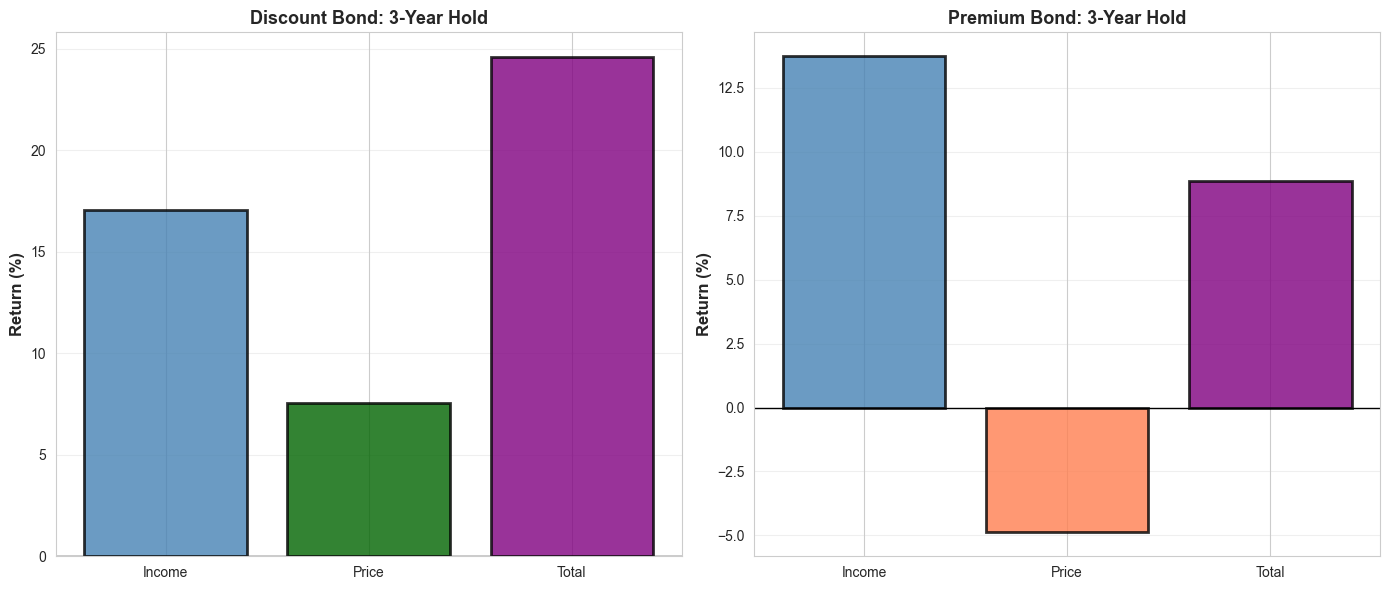

In [30]:
# Visualize decomposition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

components = ['Income', 'Price', 'Total']
values_disc = [result_disc['income_return']*100, result_disc['price_return']*100, result_disc['total_return']*100]
values_prem = [result_prem['income_return']*100, result_prem['price_return']*100, result_prem['total_return']*100]
colors = ['steelblue', 'darkgreen', 'purple']

ax1.bar(components, values_disc, color=colors, edgecolor='black', linewidth=2, alpha=0.8)
ax1.set_ylabel('Return (%)', fontsize=12, fontweight='bold')
ax1.set_title('Discount Bond: 3-Year Hold', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(0, color='black', linewidth=1)

ax2.bar(components, values_prem, color=['steelblue', 'coral', 'purple'], edgecolor='black', linewidth=2, alpha=0.8)
ax2.set_ylabel('Return (%)', fontsize=12, fontweight='bold')
ax2.set_title('Premium Bond: 3-Year Hold', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

## 6.2 Bond Price Return Modeling: The Challenge

Future bond prices depend on future yields:

$$P_h = \sum_{t=1}^{n-h} \frac{c}{(1 + y_h)^{t}} + \frac{F}{(1 + y_h)^{n-h}}$$

The problem: future yields are **uncertain**. We need models to estimate Pₕ under different yield scenarios.

## 6.3 Approach 1: Full Valuation (Repricing)

**Method**: Directly reprice the bond under different yield scenarios.

**Advantages**: Exact, no approximation errors  
**Disadvantages**: Computationally intensive, requires yield forecasts

In [31]:
# Full valuation scenario analysis
P0_full = price_bond_ytm(50, 1000, 5, 0.08)
y0_full = 0.08
holding_period = 2
years_remain = 5 - holding_period
coupons_2y = 50 * 2

yield_changes = np.linspace(-0.03, 0.03, 13)
full_val_results = []

for dy in yield_changes:
    y_h = y0_full + dy
    P_h = price_bond_ytm(50, 1000, years_remain, y_h)
    price_return = (P_h - P0_full) / P0_full
    income_return = coupons_2y / P0_full
    total_return = (coupons_2y + P_h - P0_full) / P0_full
    full_val_results.append({
        'Yield Change (%)': dy * 100,
        'Horizon Price': P_h,
        'Price Return (%)': price_return * 100,
        'Total Return (%)': total_return * 100
    })

df_full = pd.DataFrame(full_val_results)
print("FULL VALUATION SCENARIO ANALYSIS")
print(df_full[::3].to_string(index=False, float_format=lambda x: f'{x:.2f}'))

FULL VALUATION SCENARIO ANALYSIS
 Yield Change (%)  Horizon Price  Price Return (%)  Total Return (%)
            -3.00        1000.00             13.61             24.97
            -1.50         960.27              9.09             20.46
             0.00         922.69              4.82             16.19
             1.50         887.10              0.78             12.14
             3.00         853.38             -3.05              8.31


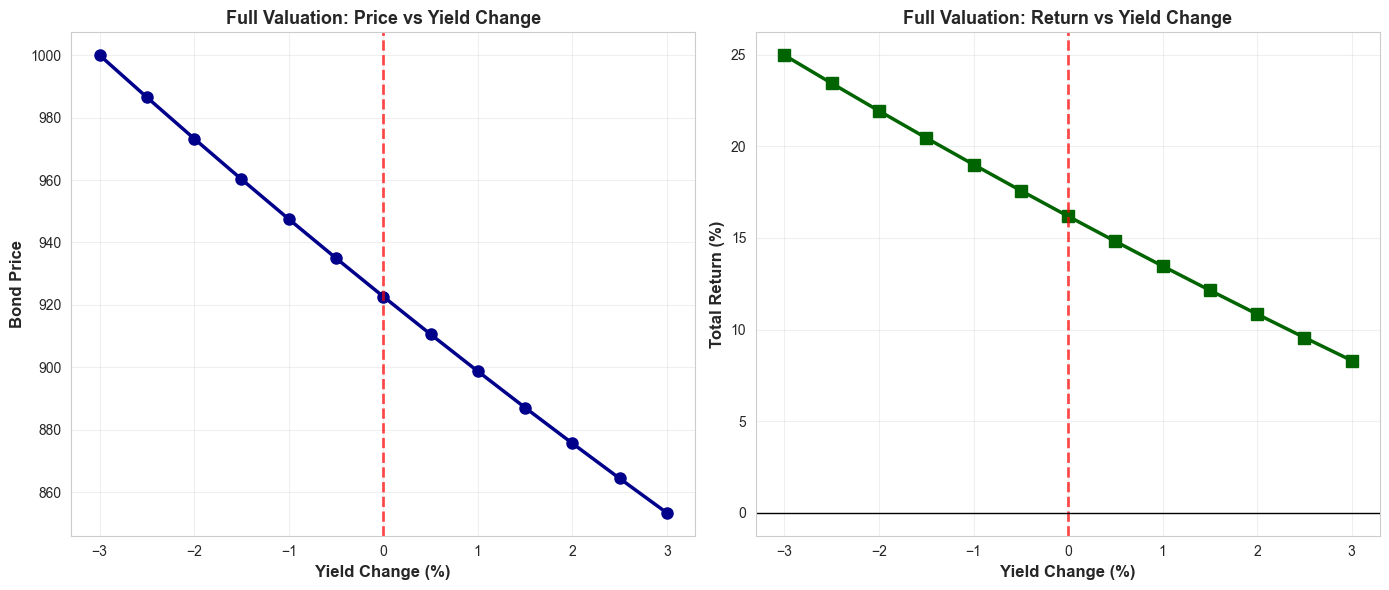

In [32]:
# Visualize full valuation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(df_full['Yield Change (%)'], df_full['Horizon Price'], 'o-', linewidth=2.5, markersize=8, color='darkblue')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.set_xlabel('Yield Change (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Bond Price', fontsize=12, fontweight='bold')
ax1.set_title('Full Valuation: Price vs Yield Change', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(df_full['Yield Change (%)'], df_full['Total Return (%)'], 's-', linewidth=2.5, markersize=8, color='darkgreen')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Yield Change (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Return (%)', fontsize=12, fontweight='bold')
ax2.set_title('Full Valuation: Return vs Yield Change', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6.4 Approach 2: Forward Rate Pricing

Use **forward rates** implied by today's spot curve (no-arbitrage baseline).

**Forward rate**: $$f_{h,T} = \left[\frac{(1 + s_T)^T}{(1 + s_h)^h}\right]^{1/(T-h)} - 1$$

**Advantages**: Theoretically sound, market-implied, no forecasting  
**Disadvantages**: Single scenario, doesn't capture uncertainty

In [33]:
# Forward rate calculation
def calculate_forward_rate(s_T, T, s_h, h):
    """Calculate forward rate from time h to time T."""
    return ((1 + s_T)**T / (1 + s_h)**h)**(1/(T-h)) - 1

# Example spot curve
maturities = np.array([1, 2, 3, 4, 5, 7, 10])
spot_rates = np.array([0.030, 0.035, 0.040, 0.042, 0.045, 0.050, 0.055])

# Horizon = 2 years
horizon_fwd = 2
s_h = np.interp(horizon_fwd, maturities, spot_rates)

# Forward rates at horizon for remaining 3 years
forward_rates_3y = []
for t in range(1, 4):
    T = horizon_fwd + t
    s_T = np.interp(T, maturities, spot_rates)
    f = calculate_forward_rate(s_T, T, s_h, horizon_fwd)
    forward_rates_3y.append(f)

# Price bond with forward rates
P_h_fwd = (50 / (1 + forward_rates_3y[0])**1 + 
           50 / (1 + forward_rates_3y[1])**2 + 
           (50 + 1000) / (1 + forward_rates_3y[2])**3)

print("FORWARD RATE PRICING")
print(f"Forward rates at t={horizon_fwd} for remaining 3 years:")
for i, f in enumerate(forward_rates_3y, 1):
    print(f"  {i}-year forward: {f*100:.2f}%")
print(f"\nBond price at horizon (forward rates): {P_h_fwd:.2f}")

FORWARD RATE PRICING
Forward rates at t=2 for remaining 3 years:
  1-year forward: 5.01%
  2-year forward: 4.90%
  3-year forward: 5.17%

Bond price at horizon (forward rates): 995.64


## 6.5 Approach 3: Nelson-Siegel Term Structure Model

Parametric yield curve model:

$$y(\tau) = \beta_0 + \beta_1 \frac{1 - e^{-\lambda\tau}}{\lambda\tau} + \beta_2 \left(\frac{1 - e^{-\lambda\tau}}{\lambda\tau} - e^{-\lambda\tau}\right)$$

**Factors**:
- β₀ = Level (long-term rate)
- β₁ = Slope (short-long spread)
- β₂ = Curvature (medium-term hump)

**Advantages**: Parsimonious, smooth curves, easy scenario analysis

In [34]:
def nelson_siegel(tau, beta0, beta1, beta2, lambda_param):
    """Nelson-Siegel yield curve model."""
    factor1 = (1 - np.exp(-lambda_param * tau)) / (lambda_param * tau)
    factor2 = factor1 - np.exp(-lambda_param * tau)
    return beta0 + beta1 * factor1 + beta2 * factor2

def fit_nelson_siegel(maturities, spot_rates, lambda_init=0.5):
    """Fit Nelson-Siegel to spot curve."""
    def objective(params):
        beta0, beta1, beta2 = params
        fitted = nelson_siegel(maturities, beta0, beta1, beta2, lambda_init)
        return np.sum((fitted - spot_rates)**2)
    
    x0 = [spot_rates[-1], spot_rates[0] - spot_rates[-1], 0.0]
    result = minimize(objective, x0, method='BFGS')
    return result.x[0], result.x[1], result.x[2], lambda_init

# Fit to spot curve
beta0, beta1, beta2, lambda_ns = fit_nelson_siegel(maturities, spot_rates)

print("NELSON-SIEGEL PARAMETRIC MODEL")
print(f"β₀ (Level): {beta0*100:.3f}%")
print(f"β₁ (Slope): {beta1*100:.3f}%")
print(f"β₂ (Curvature): {beta2*100:.3f}%")
print(f"λ (Decay): {lambda_ns:.4f}")

# Generate fitted curve
tau_fine = np.linspace(0.5, 10, 100)
fitted_yields = nelson_siegel(tau_fine, beta0, beta1, beta2, lambda_ns)

NELSON-SIEGEL PARAMETRIC MODEL
β₀ (Level): 6.724%
β₁ (Slope): -4.193%
β₂ (Curvature): -2.213%
λ (Decay): 0.5000


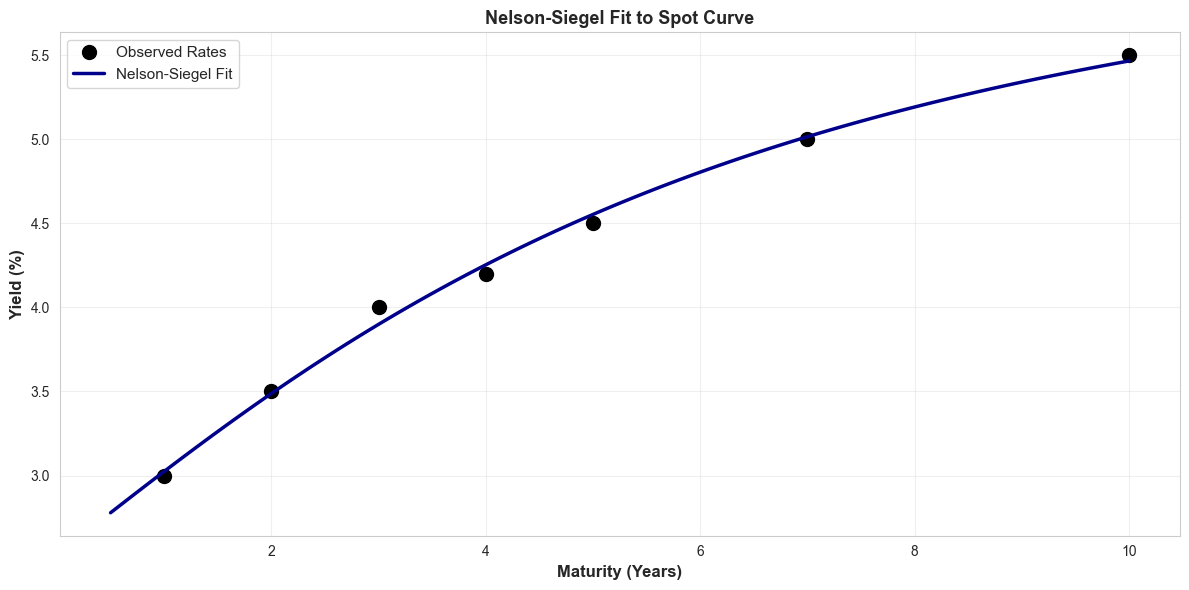

In [35]:
# Visualize Nelson-Siegel fit
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(maturities, spot_rates * 100, 'o', markersize=10, color='black', label='Observed Rates')
ax.plot(tau_fine, fitted_yields * 100, '-', linewidth=2.5, color='darkblue', label='Nelson-Siegel Fit')
ax.set_xlabel('Maturity (Years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Yield (%)', fontsize=12, fontweight='bold')
ax.set_title('Nelson-Siegel Fit to Spot Curve', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
def price_bond_ytm(coupon, face_value, years_remaining, ytm):
    """Price bond using YTM."""
    if years_remaining <= 0:
        return face_value
    price = sum(coupon / (1 + ytm)**t for t in range(1, int(years_remaining) + 1))
    price += face_value / (1 + ytm)**int(years_remaining)
    return price

def total_return_decomposition(P0, Ph, coupons_received, reinv_rate=0.0):
    """Decompose total return into income and price components."""
    h = len(coupons_received)
    fv_coupons = sum(coupons_received[i] * (1 + reinv_rate)**(h - i - 1) for i in range(h))
    
    income_return = fv_coupons / P0
    price_return = (Ph - P0) / P0
    total_return = (fv_coupons + Ph - P0) / P0
    
    return {'fv_coupons': fv_coupons, 'income_return': income_return, 
            'price_return': price_return, 'total_return': total_return}

print('Helper functions loaded successfully!')

Helper functions loaded successfully!


We now apply the Nelson-Siegel model to model the total return of a bond.

In [37]:
# Define bond to analyze
bond_coupon = 50
bond_face = 1000
bond_maturity = 5  # Years
bond_ytm_today = nelson_siegel(np.array([bond_maturity]), beta0, beta1, beta2, lambda_ns)[0]

# Initial bond price (using NS curve)
P0_ns = price_bond_ytm(bond_coupon, bond_face, bond_maturity, bond_ytm_today)

# Holding period
horizon_ns = 2  # 2 years
remaining_maturity_at_horizon = bond_maturity - horizon_ns
coupons_during_horizon = bond_coupon * horizon_ns

print(f'Bond Characteristics:')
print(f'  Coupon: {bond_coupon}')
print(f'  Initial maturity: {bond_maturity} years')
print(f'  Initial price (from NS): {P0_ns:.2f}')
print(f'  Initial YTM: {bond_ytm_today*100:.2f}%')
print(f'  Holding period: {horizon_ns} years')
print(f'  Remaining maturity at horizon: {remaining_maturity_at_horizon} years')
print(f'  Coupons received: {coupons_during_horizon}')

Bond Characteristics:
  Coupon: 50
  Initial maturity: 5 years
  Initial price (from NS): 1019.59
  Initial YTM: 4.55%
  Holding period: 2 years
  Remaining maturity at horizon: 3 years
  Coupons received: 100


In [38]:
# Define scenarios for Nelson-Siegel parameters at horizon
scenarios_ns = {
    'Base Case': {'beta0': beta0, 'beta1': beta1, 'beta2': beta2},
    'Level +100bp': {'beta0': beta0 + 0.01, 'beta1': beta1, 'beta2': beta2},
    'Steepening': {'beta0': beta0, 'beta1': beta1 - 0.02, 'beta2': beta2},
    'Flattening': {'beta0': beta0, 'beta1': beta1 + 0.02, 'beta2': beta2},
    'More Curvature': {'beta0': beta0, 'beta1': beta1, 'beta2': beta2 + 0.01}
}

results_ns_tr = []

for scenario_name, params in scenarios_ns.items():
    beta0, beta1, beta2 = params['beta0'], params['beta1'], params['beta2']
    
    # Yield at horizon using scenario parameters
    y_horizon = nelson_siegel(np.array([remaining_maturity_at_horizon]), beta0, beta1, beta2, lambda_ns)[0]
    
    # Price at horizon
    P_horizon = price_bond_ytm(bond_coupon, bond_face, remaining_maturity_at_horizon, y_horizon)
    
    # Returns
    income_return = coupons_during_horizon / P0_ns
    price_return = (P_horizon - P0_ns) / P0_ns
    total_return = (coupons_during_horizon + P_horizon - P0_ns) / P0_ns
    
    results_ns_tr.append({
        'Scenario': scenario_name,
        'YTM at Horizon': y_horizon * 100,
        'Price at Horizon': P_horizon,
        'Income Return (%)': income_return * 100,
        'Price Return (%)': price_return * 100,
        'Total Return (%)': total_return * 100
    })

df_ns_tr = pd.DataFrame(results_ns_tr)
print('\n' + '='*100)
print('TOTAL RETURN UNDER NELSON-SIEGEL SCENARIOS (2-Year Holding Period)')
print('='*100)
print(df_ns_tr.to_string(index=False, float_format=lambda x: f'{x:.2f}'))


TOTAL RETURN UNDER NELSON-SIEGEL SCENARIOS (2-Year Holding Period)
      Scenario  YTM at Horizon  Price at Horizon  Income Return (%)  Price Return (%)  Total Return (%)
     Base Case            3.90           1030.60               9.81              1.08             10.89
  Level +100bp            4.90           1002.74               9.81             -1.65              8.16
    Steepening            2.86           1060.59               9.81              4.02             13.83
    Flattening            4.94           1001.76               9.81             -1.75              8.06
More Curvature            4.19           1022.28               9.81              0.26             10.07


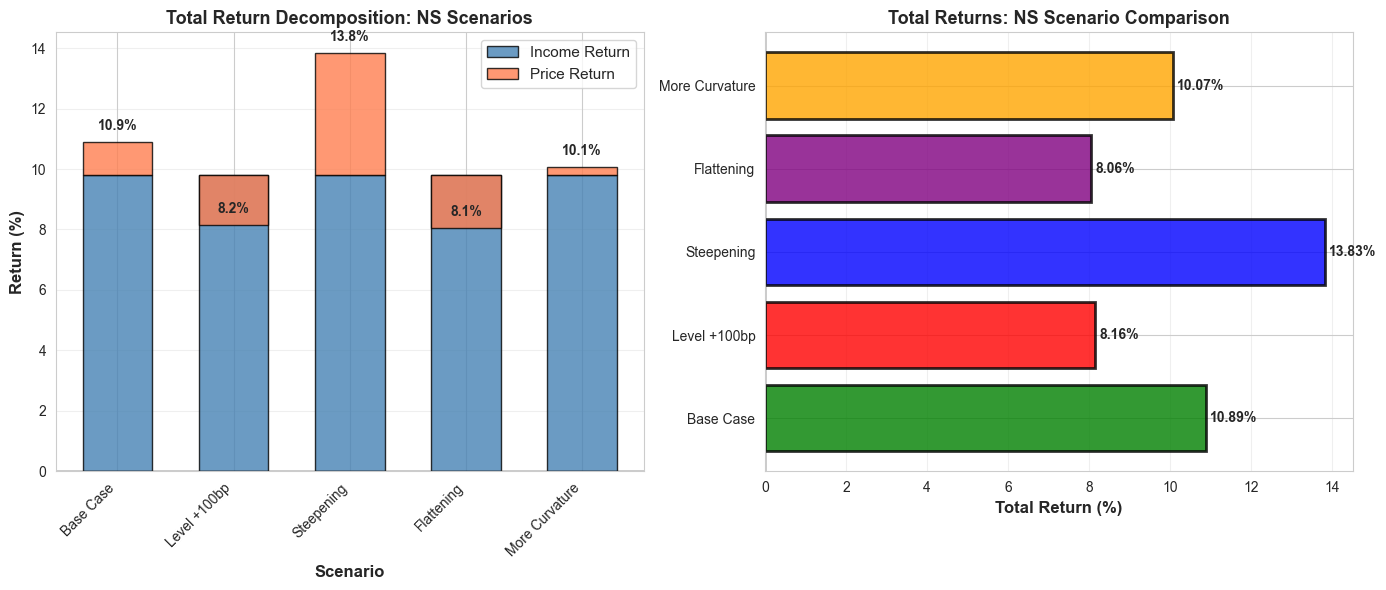

Visualization complete


In [39]:
# Visualize total returns across scenarios
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scenario_names = df_ns_tr['Scenario'].values
income_rets = df_ns_tr['Income Return (%)'].values
price_rets = df_ns_tr['Price Return (%)'].values
total_rets = df_ns_tr['Total Return (%)'].values

# Stacked bar chart
x_pos = np.arange(len(scenario_names))
width = 0.6

ax1 = axes[0]
bar1 = ax1.bar(x_pos, income_rets, width, label='Income Return', color='steelblue', edgecolor='black', alpha=0.8)
bar2 = ax1.bar(x_pos, price_rets, width, bottom=income_rets, label='Price Return', color='coral', edgecolor='black', alpha=0.8)

ax1.set_xlabel('Scenario', fontsize=12, fontweight='bold')
ax1.set_ylabel('Return (%)', fontsize=12, fontweight='bold')
ax1.set_title('Total Return Decomposition: NS Scenarios', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(scenario_names, rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(0, color='black', linewidth=1)

# Add total return labels
for i, total in enumerate(total_rets):
    ax1.text(i, total + 0.3, f'{total:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Total return comparison
ax2 = axes[1]
colors_scenarios = ['green', 'red', 'blue', 'purple', 'orange']
bars = ax2.barh(scenario_names, total_rets, color=colors_scenarios, edgecolor='black', linewidth=2, alpha=0.8)
ax2.set_xlabel('Total Return (%)', fontsize=12, fontweight='bold')
ax2.set_title('Total Returns: NS Scenario Comparison', fontsize=13, fontweight='bold')
ax2.axvline(0, color='black', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, total_rets)):
    ax2.text(val + 0.1, i, f'{val:.2f}%', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print('Visualization complete')

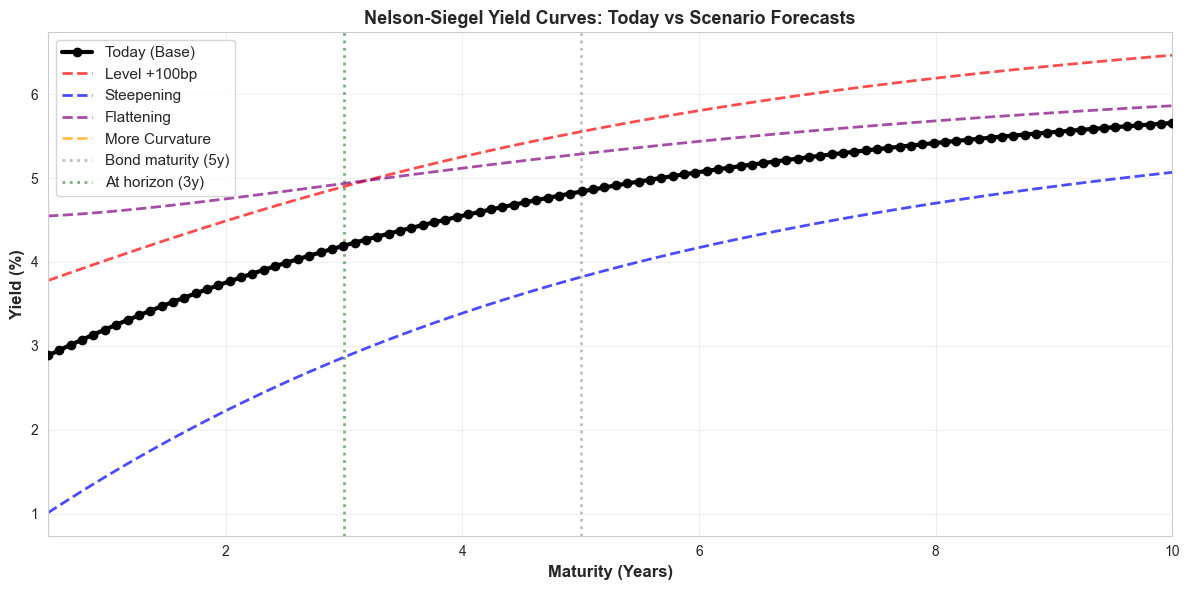

Yield curve scenarios visualized


In [40]:
# Show yield curves for each scenario
fig, ax = plt.subplots(figsize=(12, 6))

tau_fine = np.linspace(0.5, 10, 100)

# Plot today's curve
y_today = nelson_siegel(tau_fine, beta0, beta1, beta2, lambda_ns)
ax.plot(tau_fine, y_today * 100, 'o-', linewidth=3, markersize=6, color='black', label='Today (Base)', zorder=10)

# Plot scenario curves
scenario_colors = {'Level +100bp': 'red', 'Steepening': 'blue', 'Flattening': 'purple', 'More Curvature': 'orange'}

for scenario_name, params in list(scenarios_ns.items())[1:]:  # Skip base case
    if scenario_name in scenario_colors:
        beta0, beta1, beta2 = params['beta0'], params['beta1'], params['beta2']
        y_scenario = nelson_siegel(tau_fine, beta0, beta1, beta2, lambda_ns)
        ax.plot(tau_fine, y_scenario * 100, linestyle='--', linewidth=2, color=scenario_colors[scenario_name], label=scenario_name, alpha=0.7)

# Mark bond position
ax.axvline(bond_maturity, color='gray', linestyle=':', linewidth=2, alpha=0.5, label=f'Bond maturity ({bond_maturity}y)')
ax.axvline(remaining_maturity_at_horizon, color='darkgreen', linestyle=':', linewidth=2, alpha=0.5, label=f'At horizon ({remaining_maturity_at_horizon}y)')

ax.set_xlabel('Maturity (Years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Yield (%)', fontsize=12, fontweight='bold')
ax.set_title('Nelson-Siegel Yield Curves: Today vs Scenario Forecasts', fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0.5, 10)

plt.tight_layout()
plt.show()

print('Yield curve scenarios visualized')

## 6.6 Approach 4: Vasicek Model - Monte Carlo Simulation

**Vasicek SDE** with mean reversion:

$$dr_t = \kappa(\theta - r_t)dt + \sigma dW_t$$

**Discrete implementation (Euler scheme)**:

$$r_{t+\Delta t} = r_t + \kappa(\theta - r_t)\Delta t + \sigma\sqrt{\Delta t} \cdot \epsilon_t$$

**Parameters**:
- κ = Mean reversion speed
- θ = Long-term mean
- σ = Volatility

**Advantages**: Realistic mean reversion, full return distribution, risk metrics  
**Disadvantages**: Computationally intensive, parameter estimation needed

In [41]:
def simulate_vasicek(r0, kappa, theta, sigma, horizon, n_sims, dt=0.1):
    """
    Simulate Vasicek model: dr_t = kappa*(theta - r_t)*dt + sigma*dW_t
    
    Returns: array of shape (n_sims, n_steps)
    """
    n_steps = int(horizon / dt) + 1
    rates = np.zeros((n_sims, n_steps))
    rates[:, 0] = r0
    
    for step in range(n_steps - 1):
        # Generate random shocks
        dW = np.random.normal(0, np.sqrt(dt), n_sims)
        
        # Update rates: r_new = r_old + kappa*(theta - r_old)*dt + sigma*dW
        rates[:, step + 1] = (rates[:, step] + 
                             kappa * (theta - rates[:, step]) * dt + 
                             sigma * dW)
        
        # Floor at small positive value to avoid negative rates
        rates[:, step + 1] = np.maximum(rates[:, step + 1], 0.001)
    
    return rates

# Vasicek parameters
r0_vas = 0.08
kappa_vas = 0.15
theta_vas = 0.05
sigma_vas = 0.02
horizon_vas = 2
n_sims = 10000

# Run simulation
rate_paths = simulate_vasicek(r0_vas, kappa_vas, theta_vas, sigma_vas, horizon_vas, n_sims, dt=0.1)
terminal_rates = rate_paths[:, -1]

print("="*80)
print("VASICEK MODEL: MONTE CARLO SIMULATION")
print("="*80)
print()
print("Parameters:")
print(f"  r₀ = {r0_vas*100:.1f}%,  κ = {kappa_vas:.2f},  θ = {theta_vas*100:.1f}%,  σ = {sigma_vas*100:.1f}%")
print(f"  Half-life of shocks: {np.log(2)/kappa_vas:.2f} years")
print()
print(f"Terminal Rate Distribution (t = {horizon_vas} years):")
print(f"  Mean: {np.mean(terminal_rates)*100:.2f}%")
print(f"  Std Dev: {np.std(terminal_rates)*100:.2f}%")
print(f"  Min: {np.min(terminal_rates)*100:.2f}%")
print(f"  5th Percentile: {np.percentile(terminal_rates, 5)*100:.2f}%")
print(f"  95th Percentile: {np.percentile(terminal_rates, 95)*100:.2f}%")
print(f"  Max: {np.max(terminal_rates)*100:.2f}%")

VASICEK MODEL: MONTE CARLO SIMULATION

Parameters:
  r₀ = 8.0%,  κ = 0.15,  θ = 5.0%,  σ = 2.0%
  Half-life of shocks: 4.62 years

Terminal Rate Distribution (t = 2 years):
  Mean: 7.21%
  Std Dev: 2.47%
  Min: 0.10%
  5th Percentile: 3.12%
  95th Percentile: 11.26%
  Max: 17.01%


In [42]:
# Price bonds under Vasicek scenarios
coupon_vas = 50
face_vas = 1000
P0_vas = price_bond_ytm(coupon_vas, face_vas, 5, r0_vas)

# Horizon prices for each simulated terminal rate
horizon_prices_vas = np.array([price_bond_ytm(coupon_vas, face_vas, 3, r) 
                              for r in terminal_rates])

# Calculate returns
coupons_received_vas = coupon_vas * horizon_vas
total_returns_vas = (coupons_received_vas + horizon_prices_vas - P0_vas) / P0_vas

print("\n" + "="*80)
print("BOND RETURN DISTRIBUTION (VASICEK)")
print("="*80)
print()
print(f"Initial Price: {P0_vas:.2f}")
print()
print("Total Return Statistics:")
print(f"  Mean: {np.mean(total_returns_vas)*100:.2f}%")
print(f"  Std Dev: {np.std(total_returns_vas)*100:.2f}%")
print(f"  Min: {np.min(total_returns_vas)*100:.2f}%")
print(f"  5th Percentile: {np.percentile(total_returns_vas, 5)*100:.2f}%")
print(f"  Median: {np.median(total_returns_vas)*100:.2f}%")
print(f"  95th Percentile: {np.percentile(total_returns_vas, 95)*100:.2f}%")
print(f"  Max: {np.max(total_returns_vas)*100:.2f}%")
print()
print("Risk Metrics:")
var_95 = np.percentile(total_returns_vas, 5)
cvar_95 = np.mean(total_returns_vas[total_returns_vas <= var_95])
print(f"  95% VaR: {var_95*100:.2f}%")
print(f"  95% CVaR (Expected Shortfall): {cvar_95*100:.2f}%")
print(f"  Probability of Loss: {(np.sum(total_returns_vas < 0) / n_sims)*100:.2f}%")


BOND RETURN DISTRIBUTION (VASICEK)

Initial Price: 880.22

Total Return Statistics:
  Mean: 18.72%
  Std Dev: 7.08%
  Min: -5.18%
  5th Percentile: 7.68%
  Median: 18.49%
  95th Percentile: 30.99%
  Max: 41.64%

Risk Metrics:
  95% VaR: 7.68%
  95% CVaR (Expected Shortfall): 5.13%
  Probability of Loss: 0.18%


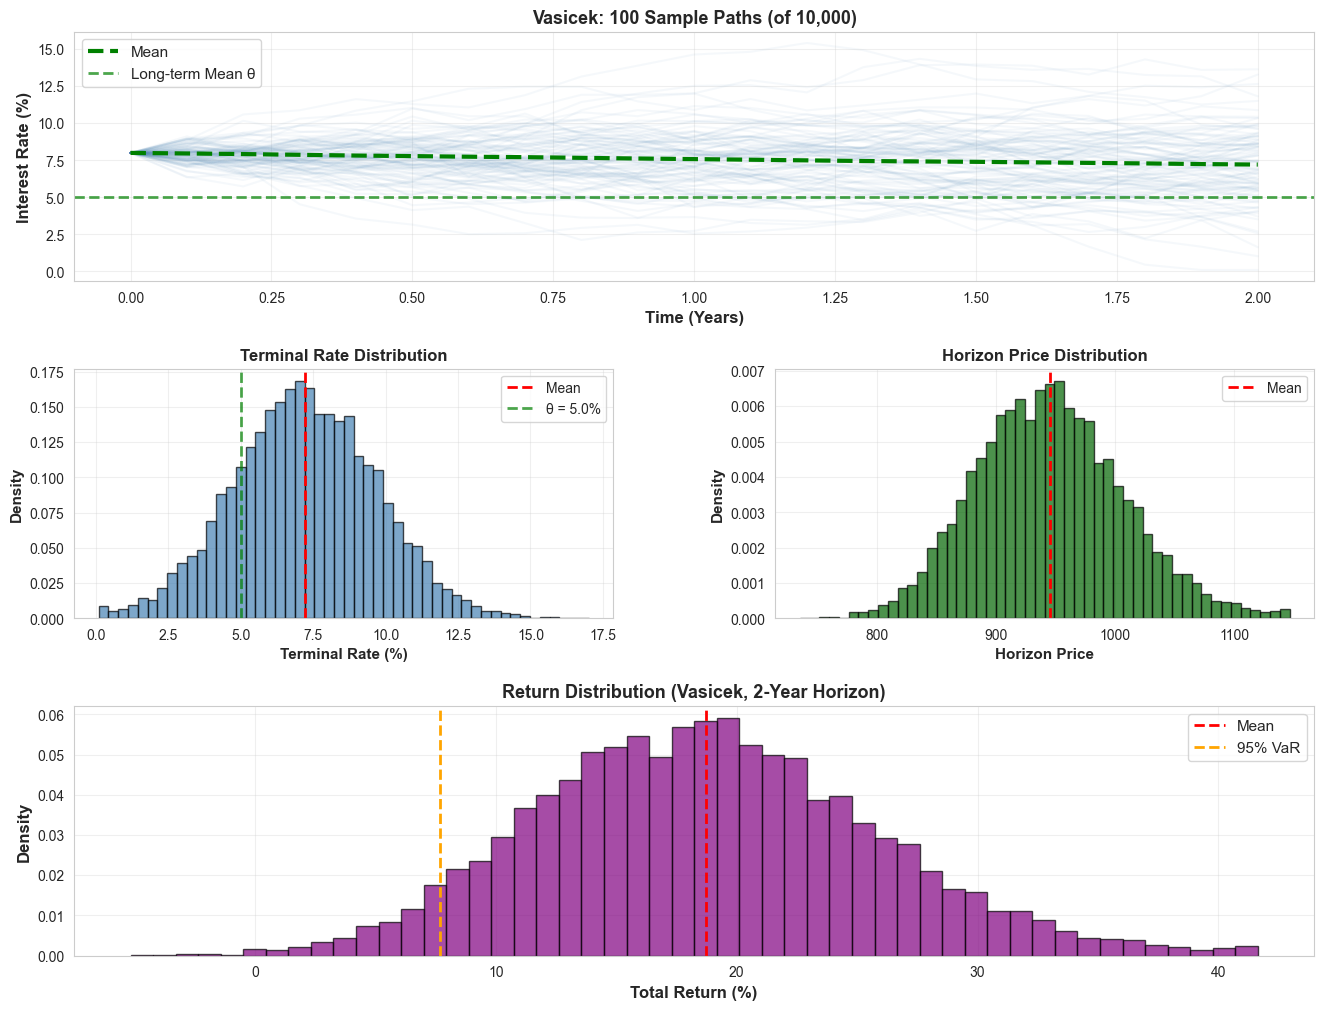

Mean reversion creates realistic rate dynamics and sensible distributions.


In [43]:
# Visualize Vasicek results
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# Sample paths
ax1 = fig.add_subplot(gs[0, :])
time_points = np.linspace(0, horizon_vas, rate_paths.shape[1])
for i in range(100):
    ax1.plot(time_points, rate_paths[i] * 100, color='steelblue', alpha=0.05)
ax1.plot(time_points, np.mean(rate_paths, axis=0) * 100, color='g', linestyle='--', linewidth=3, label='Mean')
ax1.axhline(theta_vas * 100, color='g', linestyle='--', linewidth=2, label=f'Long-term Mean θ', alpha=0.7)
ax1.set_xlabel('Time (Years)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Interest Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title(f'Vasicek: 100 Sample Paths (of {n_sims:,})', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Terminal rates
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(terminal_rates * 100, bins=50, color='steelblue', edgecolor='black', alpha=0.7, density=True)
ax2.axvline(np.mean(terminal_rates) * 100, color='r', linestyle='--', linewidth=2, label=f'Mean')
ax2.axvline(theta_vas * 100, color='g', linestyle='--', linewidth=2, label=f'θ = {theta_vas*100:.1f}%', alpha=0.7)
ax2.set_xlabel('Terminal Rate (%)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Density', fontsize=11, fontweight='bold')
ax2.set_title('Terminal Rate Distribution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Horizon prices
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(horizon_prices_vas, bins=50, color='darkgreen', edgecolor='black', alpha=0.7, density=True)
ax3.axvline(np.mean(horizon_prices_vas), color='r', linestyle='--', linewidth=2, label='Mean')
ax3.set_xlabel('Horizon Price', fontsize=11, fontweight='bold')
ax3.set_ylabel('Density', fontsize=11, fontweight='bold')
ax3.set_title('Horizon Price Distribution', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Return distribution
ax4 = fig.add_subplot(gs[2, :])
ax4.hist(total_returns_vas * 100, bins=50, color='purple', edgecolor='black', alpha=0.7, density=True)
ax4.axvline(np.mean(total_returns_vas) * 100, color='r', linestyle='--', linewidth=2, label=f'Mean')
ax4.axvline(np.percentile(total_returns_vas, 5) * 100, color='orange', linestyle='--', linewidth=2, label=f'95% VaR')
ax4.set_xlabel('Total Return (%)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Density', fontsize=12, fontweight='bold')
ax4.set_title('Return Distribution (Vasicek, 2-Year Horizon)', fontsize=13, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.show()

print("Mean reversion creates realistic rate dynamics and sensible distributions.")

## 6.7 Approach 5: Duration, Convexity & Key Rate Duration

**Taylor series approximation**:

$$\frac{\Delta P}{P} \approx -D \cdot \Delta y + \frac{1}{2} C \cdot (\Delta y)^2$$

Where D = Modified Duration, C = Convexity.

In [56]:
def calculate_duration_convexity(coupon, face, ytm, years):
    """Calculate modified duration and convexity."""
    price = sum(coupon / (1 + ytm)**t for t in range(1, years + 1)) + face / (1 + ytm)**years
    
    # Macaulay duration
    mac_dur = 0
    for t in range(1, years + 1):
        cf = coupon if t < years else coupon + face
        mac_dur += t * cf / (1 + ytm)**t
    mac_dur /= price
    
    # Modified duration
    mod_dur = mac_dur / (1 + ytm)
    
    # Convexity
    conv = 0
    for t in range(1, years + 1):
        cf = coupon if t < years else coupon + face
        conv += t * (t + 1) * cf / (1 + ytm)**(t + 2)
    conv /= price
    
    return {'price': price, 'duration': mod_dur, 'convexity': conv}

metrics = calculate_duration_convexity(50, 1000, 0.08, 5)

print("="*80)
print("DURATION & CONVEXITY")
print("="*80)
print(f"Bond: 50 coupon, 5 years, YTM = 8%")
print()
print(f"Price: {metrics['price']:.2f}")
print(f"Modified Duration: {metrics['duration']:.4f}")
print(f"Convexity: {metrics['convexity']:.4f}")
print()
print(f"Interpretation:")
print(f"  - 1% yield rise → price falls ~{metrics['duration']*100:.2f}%")
print(f"  - Convexity adjustment: +{0.5*metrics['convexity']*0.01**2*100:.4f}% per 1% move")

DURATION & CONVEXITY
Bond: 50 coupon, 5 years, YTM = 8%

Price: 880.22
Modified Duration: 4.1774
Convexity: 22.4017

Interpretation:
  - 1% yield rise → price falls ~417.74%
  - Convexity adjustment: +0.1120% per 1% move


In [57]:
# Compare exact vs approximations
yield_shocks = np.array([-0.03, -0.01, 0, 0.01, 0.03])

print("\n" + "="*80)
print("FULL VALUATION vs DURATION & CONVEXITY APPROXIMATION")
print("="*80)
print()

comparison = []
for dy in yield_shocks:
    P_exact = price_bond_ytm(50, 1000, 5, 0.08 + dy)
    dP_approx = -metrics['duration'] * metrics['price'] * dy + 0.5 * metrics['convexity'] * metrics['price'] * dy**2
    P_approx = metrics['price'] + dP_approx
    error = abs(P_exact - P_approx)
    
    comparison.append({
        'Yield Change (%)': f"{dy*100:+.0f}",
        'Exact Price': f"{P_exact:.2f}",
        'Approximation': f"{P_approx:.2f}",
        'Error': f"{error:.3f}"
    })

df_comp = pd.DataFrame(comparison)
print(df_comp.to_string(index=False))
print()
print("Duration + Convexity provides excellent approximation for moderate moves.")


FULL VALUATION vs DURATION & CONVEXITY APPROXIMATION

Yield Change (%) Exact Price Approximation Error
              -3     1000.00        999.40 0.598
              -1      918.00        917.97 0.021
              +0      880.22        880.22 0.000
              +1      844.41        844.43 0.021
              +3      778.25        778.78 0.535

Duration + Convexity provides excellent approximation for moderate moves.


### Limitations of Simple Duration:

Standard duration assumes **parallel yield shifts**. Real markets show non-parallel changes:
- Curve steepening: short rates change differently than long rates
- Curve flattening: different slope dynamics
- Butterfly moves: complex multi-factor shifts

### Partial Durations to Curve Factors:

Decompose yield changes into **level, slope, curvature**:

$$\Delta P \approx -P[D_{\text{level}}\Delta y_{\text{level}} + D_{\text{slope}}\Delta y_{\text{slope}} + D_{\text{curve}}\Delta y_{\text{curve}}]$$

### Key Rate Duration (KRD):

Sensitivity to specific maturity points on the curve:

$$D_{KRD,i} = -\frac{1}{P}\frac{\partial P}{\partial y_i}$$

Overall: $$\Delta P \approx -P \sum_i D_{KRD,i} \cdot \Delta y_i$$

---
## 6.8 Key Rate Duration (KRD) - Deep Dive
---

Key Rate Duration (KRD) is a critical tool for understanding and managing yield curve risk in fixed income portfolios. Unlike standard modified duration, which assumes parallel shifts in the yield curve, KRD measures the price sensitivity of a bond or portfolio to changes in specific maturity points on the yield curve.

### Why Key Rate Duration Matters

**Problem with Modified Duration:**
- Modified duration assumes all yields move together (parallel shift)
- Real markets show non-parallel yield curve changes
- Curve steepening, flattening, and butterfly shifts are common

**Solution: Key Rate Duration**
- Measures sensitivity to specific maturity points
- Captures non-parallel yield curve risk
- Essential for hedging and risk management

### Mathematical Definition

For a bond or portfolio, the Key Rate Duration at maturity k is defined as:

$$D_{KRD,k} = -\frac{1}{P} \frac{\partial P}{\partial y_k}$$

Where:
- \( P \) = Current bond price
- \( y_k \) = Yield at key maturity point \( k \)

**Total price change** from multiple key rate shifts:

$$ \Delta P \approx -P \sum_{k} D_{KRD,k} \cdot \Delta y_k $$

**Standard Key Maturities:**
- 2-year, 5-year, 10-year, 30-year (U.S. Treasury curve)
- Can be customized based on portfolio needs

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_krd(coupon, face, ytm, years, key_maturities, shock=0.0001):
    """
    Calculate Key Rate Duration for a bond at specified key maturities.

    Parameters:
    -----------
    coupon : float
        Annual coupon payment
    face : float
        Face value of bond
    ytm : float
        Yield to maturity
    years : int
        Maturity in years
    key_maturities : list
        List of key maturity points (e.g., [2, 5, 10, 30])
    shock : float
        Size of yield shock (default 1bp = 0.0001)

    Returns:
    --------
    dict : Dictionary of KRDs for each key maturity
    """
    # Base price
    base_price = sum(coupon / (1 + ytm)**t for t in range(1, years + 1)) + face / (1 + ytm)**years

    krds = {}

    for key_mat in key_maturities:
        if key_mat > years:
            krds[f'KRD_{key_mat}Y'] = 0.0
            continue

        # Calculate price with shocked yield at key maturity
        # Use linear interpolation weights for cash flows
        price_plus = 0
        for t in range(1, years + 1):
            cf = coupon if t < years else coupon + face

            # Weight function: 1 at key maturity, 0 elsewhere (triangular)
            if key_mat == 1:
                weight = max(0, 1 - abs(t - key_mat))
            else:
                # Find neighboring key maturities
                prev_key = max([k for k in key_maturities if k < key_mat], default=0)
                next_key = min([k for k in key_maturities if k > key_mat], default=years + 1)

                if t <= prev_key or t >= next_key:
                    weight = 0
                elif t == key_mat:
                    weight = 1
                else:
                    # Linear interpolation
                    if t < key_mat:
                        weight = (t - prev_key) / (key_mat - prev_key) if key_mat > prev_key else 0
                    else:
                        weight = (next_key - t) / (next_key - key_mat) if next_key > key_mat else 0

            # Apply shock weighted by proximity to key maturity
            shocked_ytm = ytm + shock * weight
            price_plus += cf / (1 + shocked_ytm)**t

        # Calculate KRD
        krd = -(price_plus - base_price) / (base_price * shock)
        krds[f'KRD_{key_mat}Y'] = krd

    # Add total duration for comparison
    krds['Total_Duration'] = sum(krds.values())
    krds['Base_Price'] = base_price

    return krds

print("✓ Key Rate Duration calculation function defined")


✓ Key Rate Duration calculation function defined


In [45]:
# Example: 10-year Treasury bond with 5% coupon
bond_params = {
    'coupon': 50,  # $50 annual coupon
    'face': 1000,
    'ytm': 0.05,   # 5% YTM (trading at par)
    'years': 10
}

key_maturities = [2, 5, 10, 30]

# Calculate KRDs
krds = calculate_krd(**bond_params, key_maturities=key_maturities)

print("="*60)
print("KEY RATE DURATIONS: 10-Year Treasury, 5% Coupon, Par Bond")
print("="*60)
print(f"Base Price: ${krds['Base_Price']:.2f}")
print()
print("Key Rate Durations:")
for key_mat in key_maturities:
    if key_mat <= bond_params['years']:
        print(f"  {key_mat:2d}-Year KRD: {krds[f'KRD_{key_mat}Y']:6.3f}")
    else:
        print(f"  {key_mat:2d}-Year KRD: {krds[f'KRD_{key_mat}Y']:6.3f} (beyond maturity)")
print(f"\nSum of KRDs:       {krds['Total_Duration']:6.3f}")
print()
print("Interpretation:")
print("- Most sensitivity at 10-year point (bond maturity)")
print("- Smaller sensitivities at 2Y and 5Y (intermediate cash flows)")
print("- Zero sensitivity at 30Y (bond matures before this point)")


KEY RATE DURATIONS: 10-Year Treasury, 5% Coupon, Par Bond
Base Price: $1000.00

Key Rate Durations:
   2-Year KRD:  0.244
   5-Year KRD:  0.803
  10-Year KRD:  6.649
  30-Year KRD:  0.000 (beyond maturity)

Sum of KRDs:        7.696

Interpretation:
- Most sensitivity at 10-year point (bond maturity)
- Smaller sensitivities at 2Y and 5Y (intermediate cash flows)
- Zero sensitivity at 30Y (bond matures before this point)


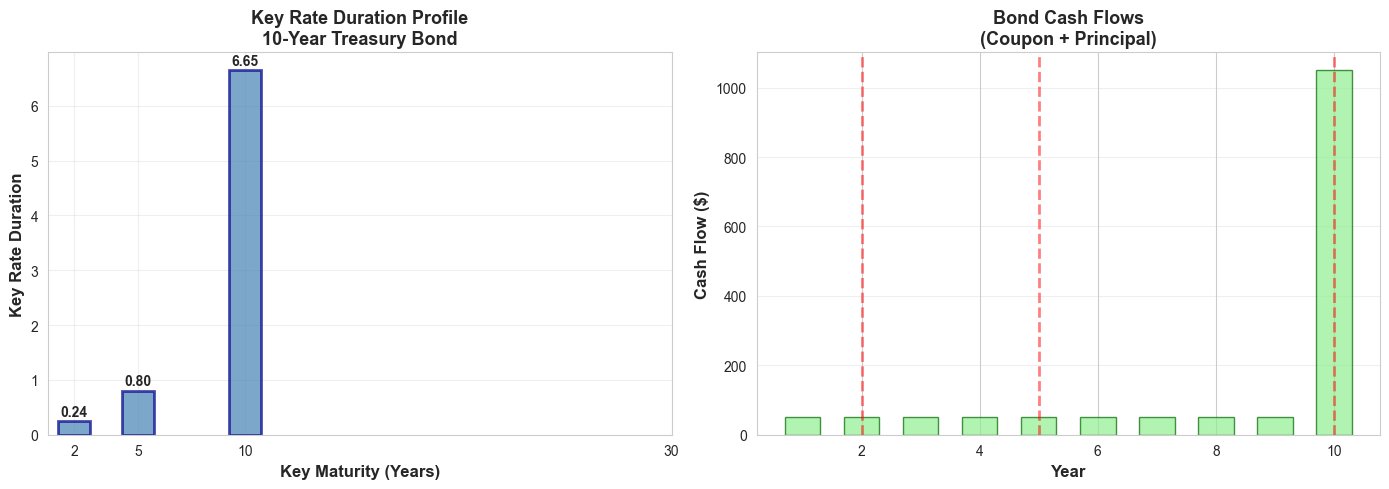


✓ KRD profile shows concentration of risk at bond maturity
✓ Red lines indicate key maturity points where yield shocks are measured


In [46]:
# Visualize KRD profile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: KRD by maturity
maturities_plot = [k for k in key_maturities if k <= bond_params['years']]
krds_plot = [krds[f'KRD_{k}Y'] for k in maturities_plot]

ax1.bar(maturities_plot, krds_plot, width=1.5, color='steelblue', 
        edgecolor='darkblue', alpha=0.7, linewidth=2)
ax1.set_xlabel('Key Maturity (Years)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Key Rate Duration', fontsize=12, fontweight='bold')
ax1.set_title('Key Rate Duration Profile\n10-Year Treasury Bond', 
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(key_maturities)

# Add value labels on bars
for i, (mat, krd) in enumerate(zip(maturities_plot, krds_plot)):
    ax1.text(mat, krd + 0.1, f'{krd:.2f}', ha='center', fontsize=10, fontweight='bold')

# Plot 2: Cash flow timeline
times = range(1, bond_params['years'] + 1)
coupons = [bond_params['coupon']] * (bond_params['years'] - 1) + [bond_params['coupon'] + bond_params['face']]

ax2.bar(times, coupons, width=0.6, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cash Flow ($)', fontsize=12, fontweight='bold')
ax2.set_title('Bond Cash Flows\n(Coupon + Principal)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Highlight key maturity points
for key_mat in maturities_plot:
    if key_mat <= bond_params['years']:
        ax2.axvline(key_mat, color='red', linestyle='--', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.show()

print("\n✓ KRD profile shows concentration of risk at bond maturity")
print("✓ Red lines indicate key maturity points where yield shocks are measured")


### Application: Non-Parallel Yield Curve Shifts

KRDs allow us to analyze realistic, non-parallel shifts in the yield curve. Let's compare three scenarios:

1. **Parallel Shift:** All rates move by the same amount (+25bp)
2. **Steepening:** Short rates up, long rates down (2Y: +30bp, 5Y: +10bp, 10Y: -10bp)
3. **Flattening:** Short rates down, long rates up (2Y: -20bp, 5Y: 0bp, 10Y: +20bp)
4. **Butterfly:** Ends move up, middle stays flat (2Y: +15bp, 5Y: 0bp, 10Y: +15bp)

In [47]:
# Define yield curve shift scenarios (in basis points)
scenarios = {
    'Parallel +25bp': {2: 25, 5: 25, 10: 25},
    'Steepening': {2: 30, 5: 10, 10: -10},
    'Flattening': {2: -20, 5: 0, 10: 20},
    'Butterfly': {2: 15, 5: 0, 10: 15}
}

print("="*80)
print("SCENARIO ANALYSIS: Impact of Non-Parallel Shifts on 10-Year Bond")
print("="*80)
print()

results = []

for scenario_name, shifts in scenarios.items():
    # Calculate total price impact using KRDs
    delta_p = 0
    for mat, shift_bp in shifts.items():
        shift_decimal = shift_bp / 10000  # Convert bp to decimal
        krd = krds[f'KRD_{mat}Y']
        delta_p += -krd * krds['Base_Price'] * shift_decimal

    pct_change = (delta_p / krds['Base_Price']) * 100
    new_price = krds['Base_Price'] + delta_p

    results.append({
        'Scenario': scenario_name,
        '2Y Shift': f"{shifts.get(2, 0):+.0f}bp",
        '5Y Shift': f"{shifts.get(5, 0):+.0f}bp",
        '10Y Shift': f"{shifts.get(10, 0):+.0f}bp",
        'Price Impact': f"${delta_p:.2f}",
        '% Change': f"{pct_change:.3f}%",
        'New Price': f"${new_price:.2f}"
    })

df_scenarios = pd.DataFrame(results)
print(df_scenarios.to_string(index=False))
print()
print("Key Insights:")
print("• Parallel shift: Clear directional impact")
print("• Steepening: Offsetting effects can reduce overall impact")  
print("• Flattening: Different from parallel despite same average")
print("• Butterfly: Complex multi-factor dynamics captured")
print()
print("⚠ Standard duration would miss these nuanced differences!")


SCENARIO ANALYSIS: Impact of Non-Parallel Shifts on 10-Year Bond

      Scenario 2Y Shift 5Y Shift 10Y Shift Price Impact % Change New Price
Parallel +25bp    +25bp    +25bp     +25bp      $-19.24  -1.924%   $980.76
    Steepening    +30bp    +10bp     -10bp        $5.12   0.512%  $1005.12
    Flattening    -20bp     +0bp     +20bp      $-12.81  -1.281%   $987.19
     Butterfly    +15bp     +0bp     +15bp      $-10.34  -1.034%   $989.66

Key Insights:
• Parallel shift: Clear directional impact
• Steepening: Offsetting effects can reduce overall impact
• Flattening: Different from parallel despite same average
• Butterfly: Complex multi-factor dynamics captured

⚠ Standard duration would miss these nuanced differences!


### Portfolio Key Rate Duration

For a portfolio of bonds, the portfolio KRD is the market-value-weighted sum of individual bond KRDs:

$$ D_{KRD,k}^{portfolio} = \sum_{i=1}^{N} w_i \cdot D_{KRD,k}^{i} $$

Where $ w_i $ is the market value weight of bond $ i $.

**Applications:**
1. **Risk Measurement:** Understand where yield curve risk is concentrated
2. **Hedging:** Match KRDs to immunize against curve shifts
3. **Relative Value:** Compare similar bonds with different KRD profiles

In [48]:
# Create a portfolio of bonds
portfolio = [
    {'name': '2-Year Treasury', 'coupon': 40, 'face': 1000, 'ytm': 0.035, 'years': 2, 'mv': 100000},
    {'name': '5-Year Treasury', 'coupon': 45, 'face': 1000, 'ytm': 0.042, 'years': 5, 'mv': 150000},
    {'name': '10-Year Treasury', 'coupon': 50, 'face': 1000, 'ytm': 0.050, 'years': 10, 'mv': 200000},
]

# Calculate portfolio KRDs
total_mv = sum(bond['mv'] for bond in portfolio)
portfolio_krds = {f'KRD_{k}Y': 0.0 for k in key_maturities}

print("="*70)
print("PORTFOLIO KEY RATE DURATION ANALYSIS")
print("="*70)
print()
print("Individual Bonds:")
print("-" * 70)

bond_results = []

for bond in portfolio:
    # Calculate KRDs for each bond
    bond_krds = calculate_krd(
        bond['coupon'], bond['face'], bond['ytm'], 
        bond['years'], key_maturities
    )

    # Store results
    weight = bond['mv'] / total_mv
    bond['weight'] = weight
    bond['krds'] = bond_krds

    # Add to portfolio KRDs
    for mat in key_maturities:
        portfolio_krds[f'KRD_{mat}Y'] += weight * bond_krds[f'KRD_{mat}Y']

    print(f"\n{bond['name']:20s} (Weight: {weight*100:.1f}%)")
    print(f"  Price: ${bond_krds['Base_Price']:.2f}  |  Value: ${bond['mv']:,.0f}")
    for mat in key_maturities:
        if mat <= bond['years']:
            print(f"  KRD {mat}Y: {bond_krds[f'KRD_{mat}Y']:6.3f}")

print()
print("="*70)
print("PORTFOLIO SUMMARY")
print("="*70)
print(f"Total Market Value: ${total_mv:,.0f}")
print()
print("Portfolio Key Rate Durations:")
for mat in key_maturities:
    print(f"  KRD {mat:2d}Y: {portfolio_krds[f'KRD_{mat}Y']:6.3f}")
print(f"\nTotal Portfolio Duration: {sum(portfolio_krds.values()):6.3f}")


PORTFOLIO KEY RATE DURATION ANALYSIS

Individual Bonds:
----------------------------------------------------------------------

2-Year Treasury      (Weight: 22.2%)
  Price: $1009.50  |  Value: $100,000
  KRD 2Y:  1.877

5-Year Treasury      (Weight: 33.3%)
  Price: $1013.28  |  Value: $150,000
  KRD 2Y:  0.222
  KRD 5Y:  4.161

10-Year Treasury     (Weight: 44.4%)
  Price: $1000.00  |  Value: $200,000
  KRD 2Y:  0.244
  KRD 5Y:  0.803
  KRD 10Y:  6.649

PORTFOLIO SUMMARY
Total Market Value: $450,000

Portfolio Key Rate Durations:
  KRD  2Y:  0.599
  KRD  5Y:  1.744
  KRD 10Y:  2.955
  KRD 30Y:  0.000

Total Portfolio Duration:  5.299


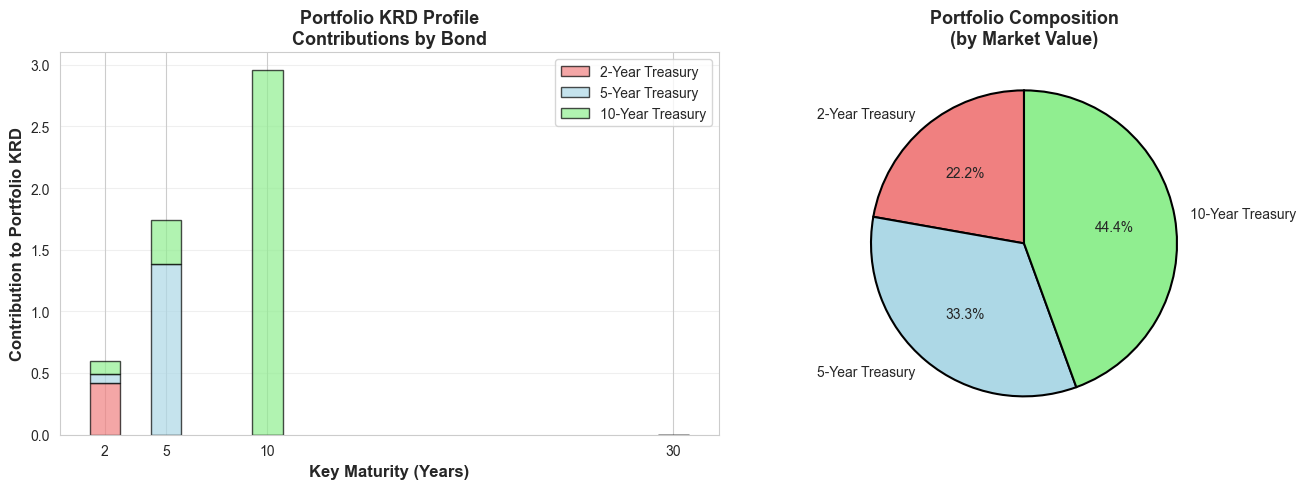


✓ Portfolio KRD shows aggregate curve risk
✓ Risk concentrated where portfolio has most exposure


In [49]:
# Visualize portfolio KRD profile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Stacked KRD contributions
mats_plot = [k for k in key_maturities]
bond_colors = ['lightcoral', 'lightblue', 'lightgreen']

bottom = np.zeros(len(mats_plot))
for i, bond in enumerate(portfolio):
    krds_bond = [bond['weight'] * bond['krds'][f'KRD_{k}Y'] for k in mats_plot]
    ax1.bar(mats_plot, krds_bond, width=1.5, bottom=bottom,
            label=bond['name'], color=bond_colors[i], 
            edgecolor='black', alpha=0.7, linewidth=1)
    bottom += krds_bond

ax1.set_xlabel('Key Maturity (Years)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Contribution to Portfolio KRD', fontsize=12, fontweight='bold')
ax1.set_title('Portfolio KRD Profile\nContributions by Bond', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticks(key_maturities)

# Plot 2: Portfolio weights
weights = [bond['weight'] * 100 for bond in portfolio]
names = [bond['name'] for bond in portfolio]

ax2.pie(weights, labels=names, autopct='%1.1f%%', startangle=90,
        colors=bond_colors, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
ax2.set_title('Portfolio Composition\n(by Market Value)', 
              fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Portfolio KRD shows aggregate curve risk")
print("✓ Risk concentrated where portfolio has most exposure")


### KRD-Based Hedging

**Objective:** Neutralize specific key rate exposures using liquid instruments (e.g., Treasury futures)

**Approach:**
1. Calculate portfolio KRDs
2. Identify key rates to hedge (e.g., 2Y, 10Y)
3. Use instruments with known KRDs to offset exposures
4. Monitor and rebalance as needed

**Example:** Hedging a 10-year bond position using 2-year and 10-year futures contracts.

In [50]:
# Hedging example: Neutralize KRD exposures
print("="*70)
print("KRD HEDGING EXAMPLE")
print("="*70)
print()
print("Objective: Hedge portfolio's 2Y and 10Y key rate exposures")
print()

# Portfolio KRDs (from previous calculation)
port_krd_2y = portfolio_krds['KRD_2Y']
port_krd_10y = portfolio_krds['KRD_10Y']

print(f"Portfolio Exposures:")
print(f"  2Y KRD: {port_krd_2y:6.3f}  (Value: ${total_mv * port_krd_2y / 100:,.0f} per 100bp)")
print(f" 10Y KRD: {port_krd_10y:6.3f}  (Value: ${total_mv * port_krd_10y / 100:,.0f} per 100bp)")
print()

# Hedging instruments (simplified)
hedge_instruments = {
    '2Y Future': {'KRD_2Y': 1.95, 'KRD_10Y': 0.05, 'Contract_Value': 200000},
    '10Y Future': {'KRD_2Y': 0.10, 'KRD_10Y': 8.50, 'Contract_Value': 100000}
}

# Calculate hedge ratios
# Solve: port_krd_2y + h1 * hedge1_krd_2y + h2 * hedge2_krd_2y ≈ 0
#        port_krd_10y + h1 * hedge1_krd_10y + h2 * hedge2_krd_10y ≈ 0

# Using matrix approach: A * h = -p
A = np.array([
    [hedge_instruments['2Y Future']['KRD_2Y'], hedge_instruments['10Y Future']['KRD_2Y']],
    [hedge_instruments['2Y Future']['KRD_10Y'], hedge_instruments['10Y Future']['KRD_10Y']]
])

p = np.array([port_krd_2y, port_krd_10y])

# Hedge ratios (negative of portfolio exposures)
hedge_ratios = np.linalg.solve(A, -p)

print("Hedging Solution:")
print(f"  Sell {hedge_ratios[0]:.2f} contracts of 2Y Future")
print(f"  Sell {hedge_ratios[1]:.2f} contracts of 10Y Future")
print()

# Verify hedge
hedged_2y = port_krd_2y + hedge_ratios[0] * hedge_instruments['2Y Future']['KRD_2Y'] + \
                          hedge_ratios[1] * hedge_instruments['10Y Future']['KRD_2Y']
hedged_10y = port_krd_10y + hedge_ratios[0] * hedge_instruments['2Y Future']['KRD_10Y'] + \
                            hedge_ratios[1] * hedge_instruments['10Y Future']['KRD_10Y']

print("After Hedging:")
print(f"  2Y KRD: {hedged_2y:6.4f}  (Residual: {abs(hedged_2y):.6f})")
print(f" 10Y KRD: {hedged_10y:6.4f}  (Residual: {abs(hedged_10y):.6f})")
print()
print("✓ Portfolio now immunized against 2Y and 10Y yield shifts")
print("⚠ Still exposed to 5Y shifts (partial hedge)")


KRD HEDGING EXAMPLE

Objective: Hedge portfolio's 2Y and 10Y key rate exposures

Portfolio Exposures:
  2Y KRD:  0.599  (Value: $2,697 per 100bp)
 10Y KRD:  2.955  (Value: $13,298 per 100bp)

Hedging Solution:
  Sell -0.29 contracts of 2Y Future
  Sell -0.35 contracts of 10Y Future

After Hedging:
  2Y KRD: 0.0000  (Residual: 0.000000)
 10Y KRD: 0.0000  (Residual: 0.000000)

✓ Portfolio now immunized against 2Y and 10Y yield shifts
⚠ Still exposed to 5Y shifts (partial hedge)


### Summary: Key Rate Duration

**Advantages:**
- Captures non-parallel yield curve risk
- Essential for sophisticated fixed income management
- Enables targeted hedging strategies
- Widely used in institutional portfolio management

**Limitations:**
- More complex than modified duration
- Requires assumptions about yield curve interpolation
- Choice of key maturities affects results
- Not as intuitive as single-number duration

**Best Practices:**
1. Use standard key maturities (2Y, 5Y, 10Y, 30Y) for consistency
2. Combine with scenario analysis for comprehensive risk assessment
3. Monitor KRD distribution across portfolio
4. Rebalance hedges as market conditions change
5. Complement with other risk measures (VaR, convexity)

**When to Use:**
- Large fixed income portfolios
- Active curve positioning strategies
- Hedging complex interest rate exposures
- Regulatory risk reporting (Basel III)

## 6.9 Summary: Comparison of All Five Approaches

| Approach | Speed | Accuracy | Best For |
|----------|-------|----------|----------|
| Full Valuation | Slow | Exact | Stress tests, regulatory |
| Forward Rates | Fast | No-arbitrage baseline | Expected return, pricing |
| Nelson-Siegel | Medium | Model-dependent | Scenario analysis |
| Vasicek Monte Carlo | Very Slow | Statistical | VaR, CVaR, risk metrics |
| Duration + KRD | Very Fast | High (moderate Δy) | Daily risk management |

### Practical Guidance:

1. **Daily risk management**: Duration + Convexity
2. **Baseline valuations**: Forward rates (no-arbitrage)
3. **Scenario analysis**: Nelson-Siegel or full valuation
4. **Risk metrics (VaR)**: Vasicek Monte Carlo
5. **Curve risk hedging**: Key Rate Duration

Each approach has strengths and weaknesses. Practitioners often combine multiple approaches for comprehensive analysis.